In [5]:
!rm -rf /kaggle/working/handwriting-generator-model
!git clone https://github.com/Shambu-K/handwriting-generator-model.git
!pip install fastdtw
%cd /kaggle/working/handwriting-generator-model/Code/STR_model

Cloning into 'handwriting-generator-model'...
remote: Enumerating objects: 1643, done.
remote: Counting objects: 100% (579/579), done.
remote: Compressing objects: 100% (358/358), done.
remote: Total 1643 (delta 253), reused 474 (delta 209), pack-reused 1064
Receiving objects: 100% (1643/1643), 453.11 MiB | 31.75 MiB/s, done.
Resolving deltas: 100% (705/705), done.
/kaggle/working/handwriting-generator-model/Code/STR_model


In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader
from model import STR_Model, STR_Model_Longer_512, STR_Model_Longer_1024
from dataset.iam_dataloader import HandwritingDataset
from loss.stroke_loss import STR_Loss_DTW, STR_Loss_Identity
from util.visualize_progress import visualize_progress, plot_losses
from fastdtw import fastdtw
from tqdm.notebook import tqdm
import os

In [7]:
def train(model, train_loader, loss_function, optimizer, device, epoch=0):
    # Setting the model to training mode
    model.train() 
    length = len(train_loader)
    # Looping over each batch from the training set 
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc=f'Epoch {epoch}', total=length, disable=True):  
        # data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  
        output = model(data)  
        loss, dtw_loss, sos_loss, eos_loss  = loss_function(output, target) 
        loss.backward()
        # Updating the model parameters
        optimizer.step() 

        if batch_idx % 100 == 0:
            print(f'   Batch: {batch_idx:<4} | Width: {data.shape[-1]:<3} | Loss: {loss.item():.4f}')
            
    return loss.item(), dtw_loss.item(), sos_loss.item(), eos_loss.item()

def model_fit(model, train_loader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint, plot=1):
    train_losses, dtw_losses, sos_losses, eos_losses = [], [], [], []
    for epoch in tqdm(range(num_epochs)):
        if epoch % plot == 0: 
            print('=====================================================================\n')
            if len(train_losses) > 0: print(f'Epoch: {epoch} | Loss: {train_losses[-1]}')
            visualize_progress(model, device, train_loader, epoch)
        loss, dtw_loss, sos_loss, eos_loss = train(model, train_loader, loss_function, optimizer, device, epoch+1)
        scheduler.step()

        train_losses.append(loss)
        dtw_losses.append(dtw_loss)
        sos_losses.append(sos_loss)
        eos_losses.append(eos_loss)

        if epoch % checkpoint == 0:
            model_file = f'./checkpoints/{model.__class__.__name__}_{epoch}_{int(loss)}.pth'
            torch.save(model.state_dict(), model_file) 
    
    return train_losses, dtw_losses, sos_losses, eos_losses

# Util functions
def set_best_model(model, checkpoint_dir):
    ''' Set the model with least loss as the best model. '''
    best_loss = 100000
    best_model = None
    for file in os.listdir(checkpoint_dir):
        if file.endswith('.pth') and file.startswith(model.__class__.__name__):
            loss = int(file.split('_')[-1].split('.')[0])
            if loss < best_loss:
                best_loss = loss
                best_model = file
    if best_model is not None:
        model.load_state_dict(torch.load(os.path.join(checkpoint_dir, best_model)))
        print(f'Best model: {best_model}')

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Training parameters
num_epochs = 75
batch_size = 16 # Archibald it is 32
checkpoint_interval = 5
learning_rate = 0.001
lr_decay = 0.97

print('Using device:', device)

Using device: cuda


In [9]:
# Load data
root_dir = '/kaggle/input/iam-dataset-word-level/Resized_Dataset/Train'
# root_dir = '../../DataSet/IAM-Online/Resized_Dataset/Train/'
dataset = HandwritingDataset(root_dir, batch_size, device, max_allowed_width=100)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

Preprocessing data: 100%|██████████| 894/894 [00:13<00:00, 67.75it/s] 


In [10]:
# For singluar image
# idx = 14000
# dataloader = [(dataset[idx][0].unsqueeze(0), dataset[idx][1].unsqueeze(0))]

In [14]:
# Model
model = STR_Model_Longer_512(relative_coords=False).to(device)
# set_best_model(model, './checkpoints/')
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)
loss_function = STR_Loss_DTW(sos_weight=5)

  0%|          | 0/75 [00:00<?, ?it/s]

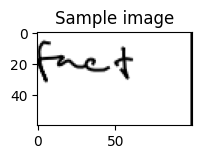

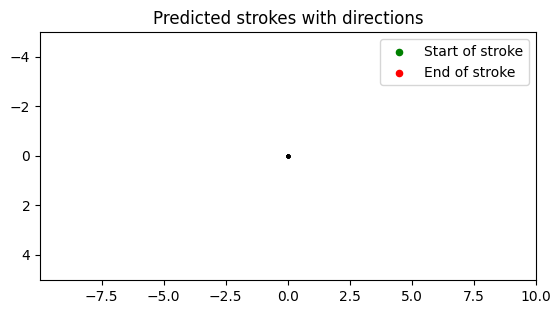

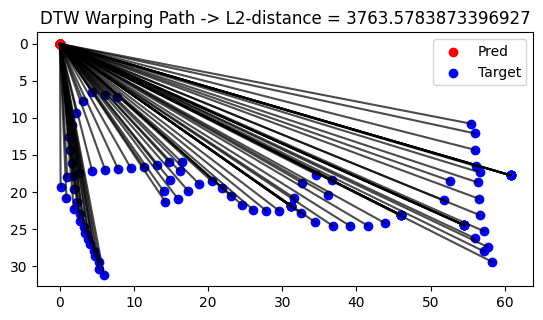

   Batch: 0    | Width: 6   | Loss: 43.3675
   Batch: 100  | Width: 46  | Loss: 19.4252
   Batch: 200  | Width: 56  | Loss: 15.3422
   Batch: 300  | Width: 64  | Loss: 11.6624
   Batch: 400  | Width: 72  | Loss: 11.3578
   Batch: 500  | Width: 78  | Loss: 10.6599
   Batch: 600  | Width: 84  | Loss: 9.6385
   Batch: 700  | Width: 90  | Loss: 10.3523
   Batch: 800  | Width: 96  | Loss: 10.6028

Epoch: 1 | Loss: 9.735162579903944


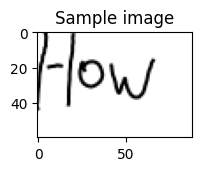

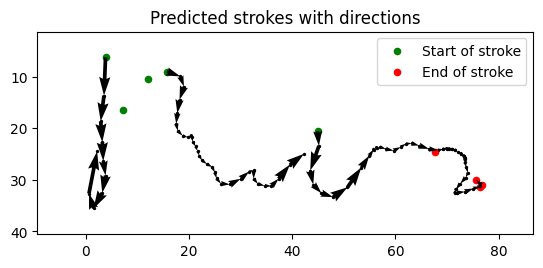

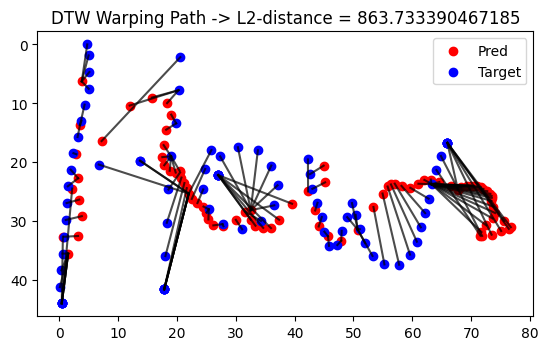

   Batch: 0    | Width: 6   | Loss: 42.0909
   Batch: 100  | Width: 46  | Loss: 11.4658
   Batch: 200  | Width: 56  | Loss: 9.4064
   Batch: 300  | Width: 64  | Loss: 8.0705
   Batch: 400  | Width: 72  | Loss: 9.7354
   Batch: 500  | Width: 78  | Loss: 9.1226
   Batch: 600  | Width: 84  | Loss: 8.3954
   Batch: 700  | Width: 90  | Loss: 9.2834
   Batch: 800  | Width: 96  | Loss: 10.2464

Epoch: 2 | Loss: 8.725005360744664


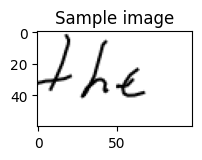

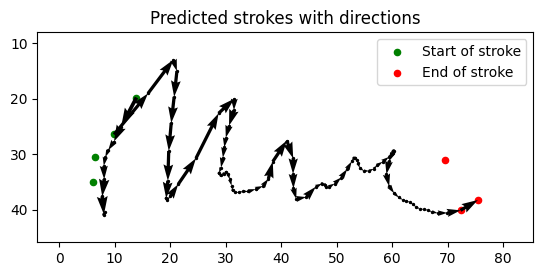

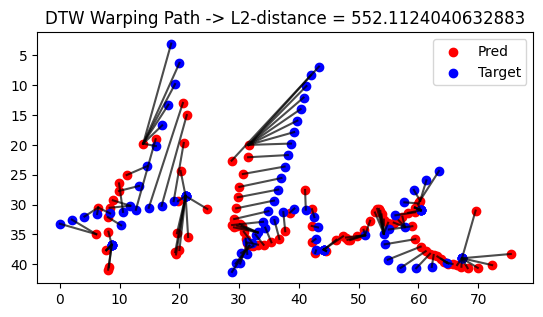

   Batch: 0    | Width: 6   | Loss: 29.7706
   Batch: 100  | Width: 46  | Loss: 9.6244
   Batch: 200  | Width: 56  | Loss: 8.5878
   Batch: 300  | Width: 64  | Loss: 7.9200
   Batch: 400  | Width: 72  | Loss: 8.7032
   Batch: 500  | Width: 78  | Loss: 8.4927
   Batch: 600  | Width: 84  | Loss: 7.8111
   Batch: 700  | Width: 90  | Loss: 9.1444
   Batch: 800  | Width: 96  | Loss: 9.6248

Epoch: 3 | Loss: 8.184949571392158


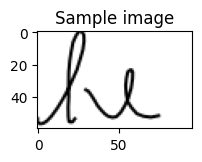

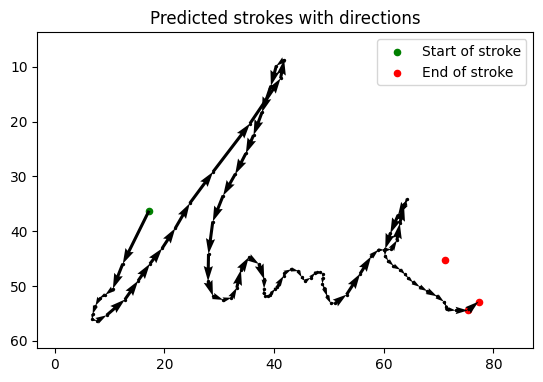

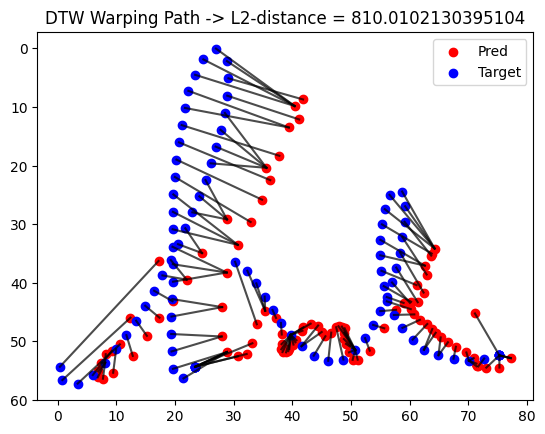

   Batch: 0    | Width: 6   | Loss: 22.3592
   Batch: 100  | Width: 46  | Loss: 9.5490
   Batch: 200  | Width: 56  | Loss: 8.8702
   Batch: 300  | Width: 64  | Loss: 7.4561
   Batch: 400  | Width: 72  | Loss: 8.0030
   Batch: 500  | Width: 78  | Loss: 7.6872
   Batch: 600  | Width: 84  | Loss: 6.7054
   Batch: 700  | Width: 90  | Loss: 8.8994
   Batch: 800  | Width: 96  | Loss: 8.9789

Epoch: 4 | Loss: 8.052384169913559


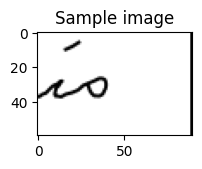

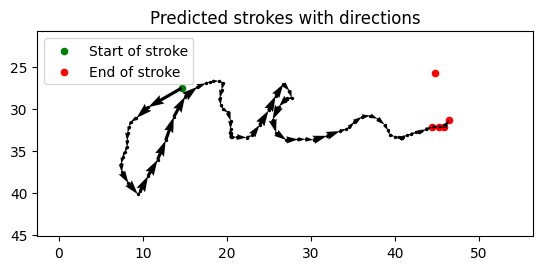

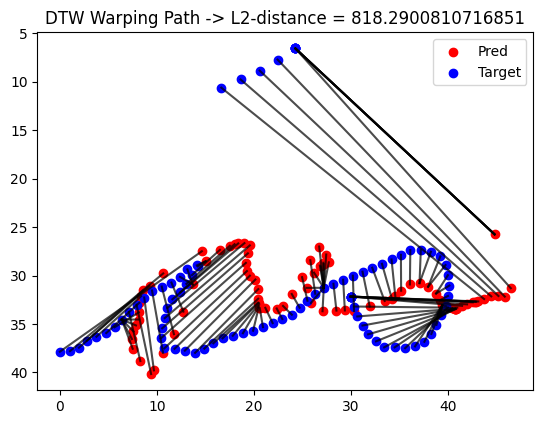

   Batch: 0    | Width: 6   | Loss: 20.9875
   Batch: 100  | Width: 46  | Loss: 8.9792
   Batch: 200  | Width: 56  | Loss: 7.2042
   Batch: 300  | Width: 64  | Loss: 7.5319
   Batch: 400  | Width: 72  | Loss: 7.9048
   Batch: 500  | Width: 78  | Loss: 7.3035
   Batch: 600  | Width: 84  | Loss: 6.8567
   Batch: 700  | Width: 90  | Loss: 7.9430
   Batch: 800  | Width: 96  | Loss: 8.9954

Epoch: 5 | Loss: 7.40051317372643


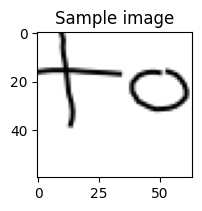

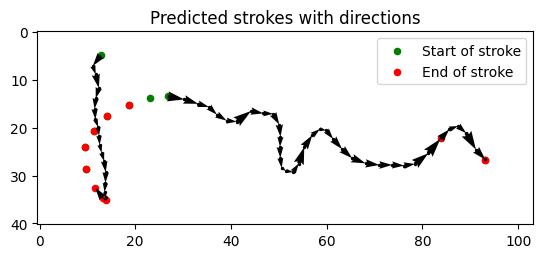

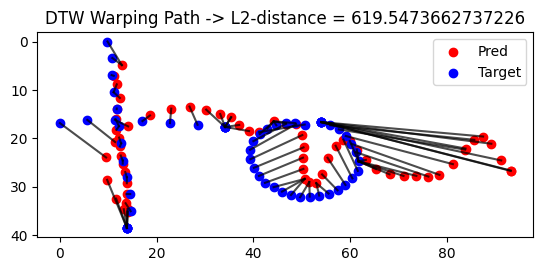

   Batch: 0    | Width: 6   | Loss: 16.2101
   Batch: 100  | Width: 46  | Loss: 7.8574
   Batch: 200  | Width: 56  | Loss: 6.9962
   Batch: 300  | Width: 64  | Loss: 7.2258
   Batch: 400  | Width: 72  | Loss: 7.3192
   Batch: 500  | Width: 78  | Loss: 7.2985
   Batch: 600  | Width: 84  | Loss: 6.5502
   Batch: 700  | Width: 90  | Loss: 7.5814
   Batch: 800  | Width: 96  | Loss: 8.3209

Epoch: 6 | Loss: 7.195173307113006


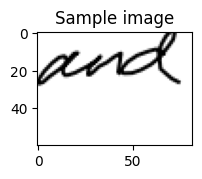

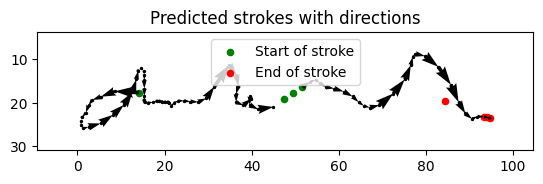

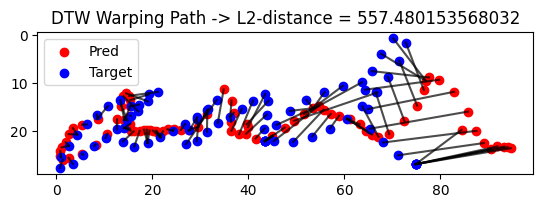

   Batch: 0    | Width: 6   | Loss: 13.9305
   Batch: 100  | Width: 46  | Loss: 7.5711
   Batch: 200  | Width: 56  | Loss: 6.2128
   Batch: 300  | Width: 64  | Loss: 7.0006
   Batch: 400  | Width: 72  | Loss: 6.9829
   Batch: 500  | Width: 78  | Loss: 6.8744
   Batch: 600  | Width: 84  | Loss: 6.0028
   Batch: 700  | Width: 90  | Loss: 7.7415
   Batch: 800  | Width: 96  | Loss: 7.7296

Epoch: 7 | Loss: 6.9669497873267545


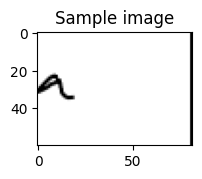

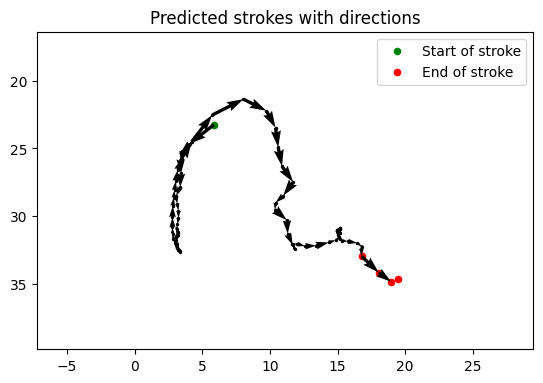

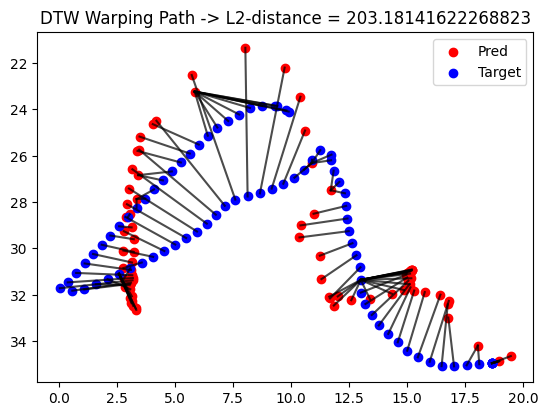

   Batch: 0    | Width: 6   | Loss: 11.0297
   Batch: 100  | Width: 46  | Loss: 6.7570
   Batch: 200  | Width: 56  | Loss: 6.0897
   Batch: 300  | Width: 64  | Loss: 6.3740
   Batch: 400  | Width: 72  | Loss: 6.6855
   Batch: 500  | Width: 78  | Loss: 6.5538
   Batch: 600  | Width: 84  | Loss: 5.6394
   Batch: 700  | Width: 90  | Loss: 7.0072
   Batch: 800  | Width: 96  | Loss: 7.4021

Epoch: 8 | Loss: 6.645364386190904


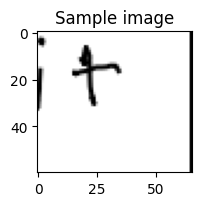

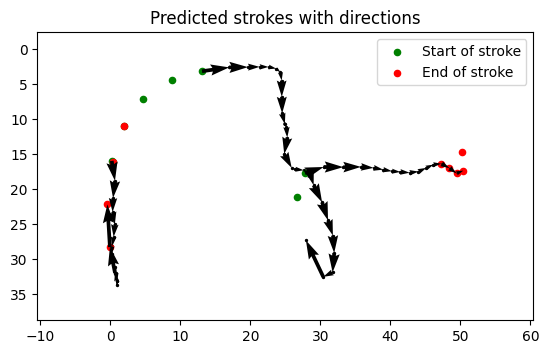

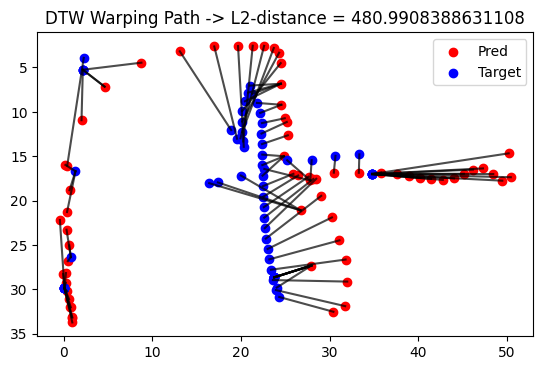

   Batch: 0    | Width: 6   | Loss: 11.0876
   Batch: 100  | Width: 46  | Loss: 6.5262
   Batch: 200  | Width: 56  | Loss: 5.6954
   Batch: 300  | Width: 64  | Loss: 5.7818
   Batch: 400  | Width: 72  | Loss: 6.1495
   Batch: 500  | Width: 78  | Loss: 6.5754
   Batch: 600  | Width: 84  | Loss: 6.1199
   Batch: 700  | Width: 90  | Loss: 6.6737
   Batch: 800  | Width: 96  | Loss: 6.5982

Epoch: 9 | Loss: 5.9344925817395735


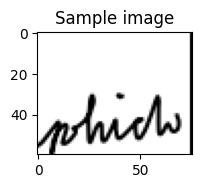

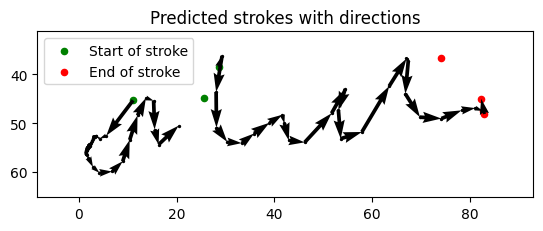

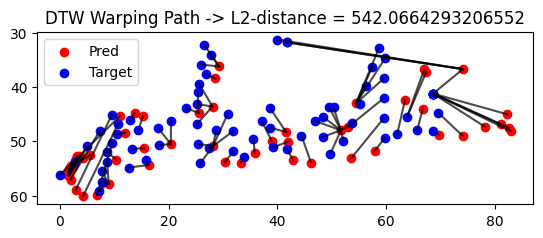

   Batch: 0    | Width: 6   | Loss: 10.4562
   Batch: 100  | Width: 46  | Loss: 6.4058
   Batch: 200  | Width: 56  | Loss: 5.5040
   Batch: 300  | Width: 64  | Loss: 5.7255
   Batch: 400  | Width: 72  | Loss: 5.7122
   Batch: 500  | Width: 78  | Loss: 5.9540
   Batch: 600  | Width: 84  | Loss: 5.0275
   Batch: 700  | Width: 90  | Loss: 6.1967
   Batch: 800  | Width: 96  | Loss: 6.4977

Epoch: 10 | Loss: 5.569959419660035


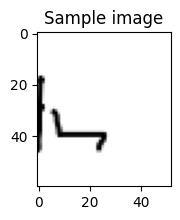

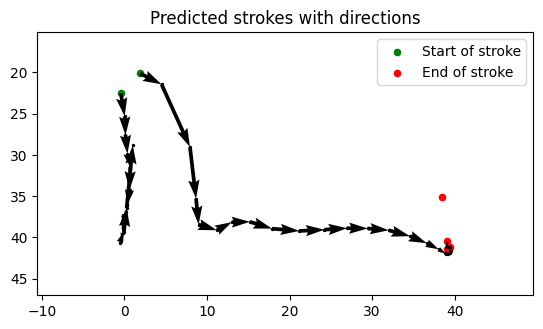

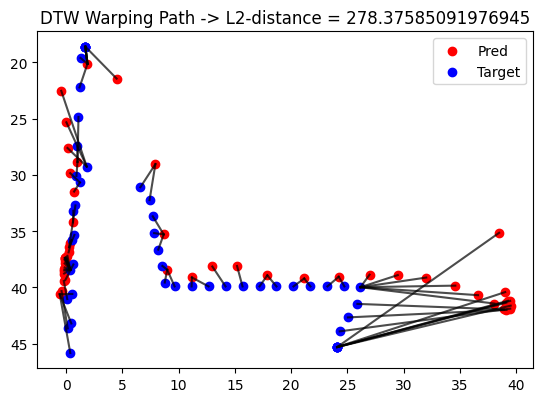

   Batch: 0    | Width: 6   | Loss: 11.1262
   Batch: 100  | Width: 46  | Loss: 6.0683
   Batch: 200  | Width: 56  | Loss: 5.3704
   Batch: 300  | Width: 64  | Loss: 4.7099
   Batch: 400  | Width: 72  | Loss: 6.5611
   Batch: 500  | Width: 78  | Loss: 5.7336
   Batch: 600  | Width: 84  | Loss: 4.9021
   Batch: 700  | Width: 90  | Loss: 6.0445
   Batch: 800  | Width: 96  | Loss: 6.3040

Epoch: 11 | Loss: 5.573600908252349


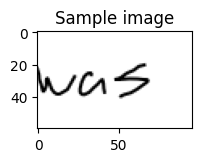

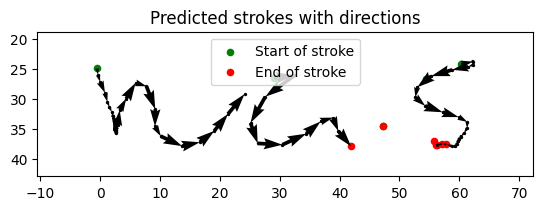

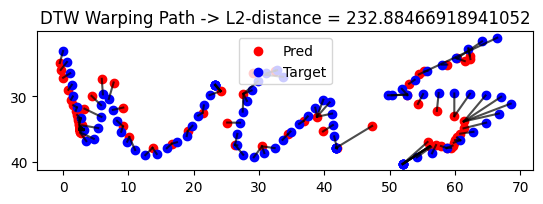

   Batch: 0    | Width: 6   | Loss: 9.1160
   Batch: 100  | Width: 46  | Loss: 5.7380
   Batch: 200  | Width: 56  | Loss: 4.7284
   Batch: 300  | Width: 64  | Loss: 4.9631
   Batch: 400  | Width: 72  | Loss: 5.2182
   Batch: 500  | Width: 78  | Loss: 5.7330
   Batch: 600  | Width: 84  | Loss: 4.6949
   Batch: 700  | Width: 90  | Loss: 5.4613
   Batch: 800  | Width: 96  | Loss: 6.3848

Epoch: 12 | Loss: 5.171523150930677


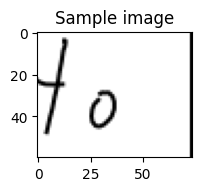

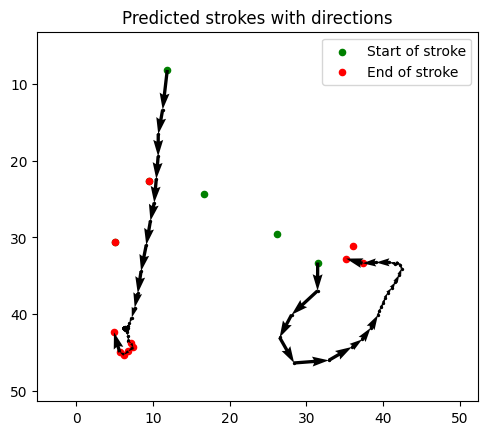

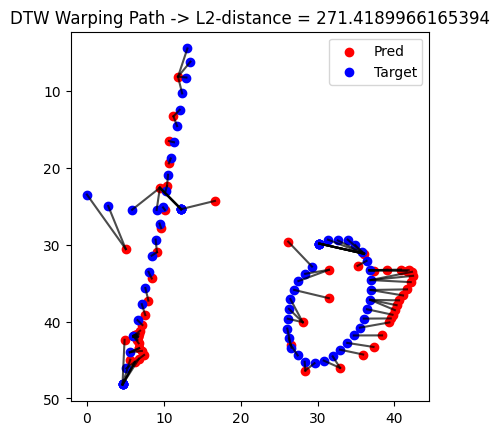

   Batch: 0    | Width: 6   | Loss: 7.8000
   Batch: 100  | Width: 46  | Loss: 5.7119
   Batch: 200  | Width: 56  | Loss: 4.8359
   Batch: 300  | Width: 64  | Loss: 5.1515
   Batch: 400  | Width: 72  | Loss: 5.3226
   Batch: 500  | Width: 78  | Loss: 5.4645
   Batch: 600  | Width: 84  | Loss: 4.6469
   Batch: 700  | Width: 90  | Loss: 5.2095
   Batch: 800  | Width: 96  | Loss: 6.0519

Epoch: 13 | Loss: 5.241779421894795


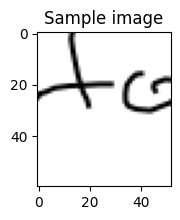

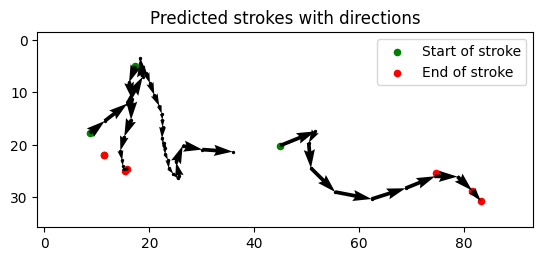

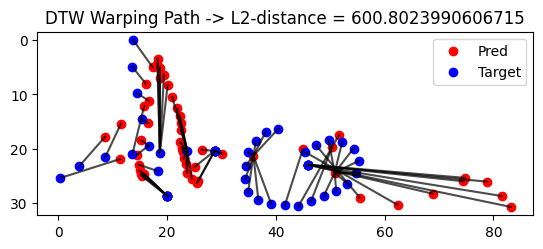

   Batch: 0    | Width: 6   | Loss: 7.7441
   Batch: 100  | Width: 46  | Loss: 5.4972
   Batch: 200  | Width: 56  | Loss: 4.5514
   Batch: 300  | Width: 64  | Loss: 4.9136
   Batch: 400  | Width: 72  | Loss: 5.2134
   Batch: 500  | Width: 78  | Loss: 5.5275
   Batch: 600  | Width: 84  | Loss: 4.3686
   Batch: 700  | Width: 90  | Loss: 5.2700
   Batch: 800  | Width: 96  | Loss: 5.6010

Epoch: 14 | Loss: 5.170599441155717


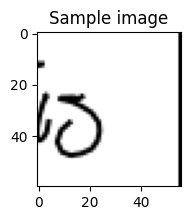

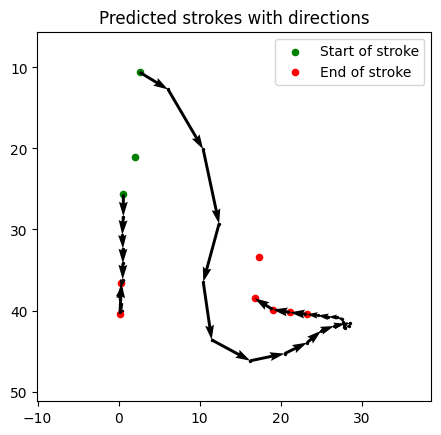

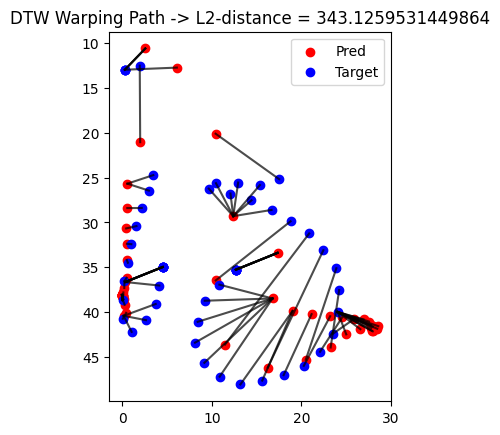

   Batch: 0    | Width: 6   | Loss: 7.6179
   Batch: 100  | Width: 46  | Loss: 5.4963
   Batch: 200  | Width: 56  | Loss: 4.4104
   Batch: 300  | Width: 64  | Loss: 4.0805
   Batch: 400  | Width: 72  | Loss: 5.2072
   Batch: 500  | Width: 78  | Loss: 5.0691
   Batch: 600  | Width: 84  | Loss: 4.1460
   Batch: 700  | Width: 90  | Loss: 5.4426
   Batch: 800  | Width: 96  | Loss: 5.5402

Epoch: 15 | Loss: 4.8563515999648175


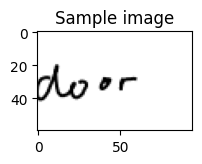

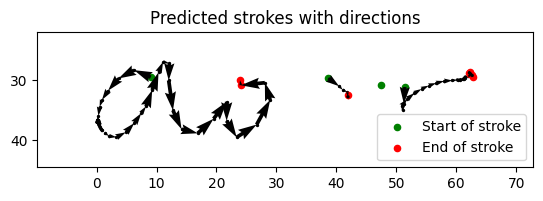

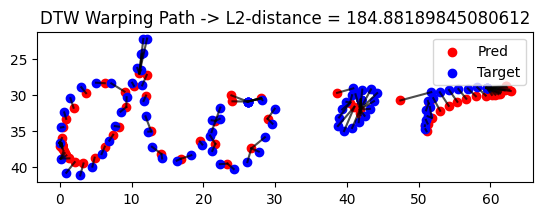

   Batch: 0    | Width: 6   | Loss: 8.0978
   Batch: 100  | Width: 46  | Loss: 5.5750
   Batch: 200  | Width: 56  | Loss: 4.5563
   Batch: 300  | Width: 64  | Loss: 4.4216
   Batch: 400  | Width: 72  | Loss: 5.1513
   Batch: 500  | Width: 78  | Loss: 5.0740
   Batch: 600  | Width: 84  | Loss: 4.0643
   Batch: 700  | Width: 90  | Loss: 5.0237
   Batch: 800  | Width: 96  | Loss: 5.4946

Epoch: 16 | Loss: 4.993466030322503


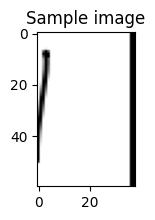

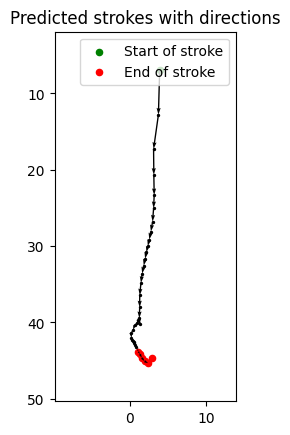

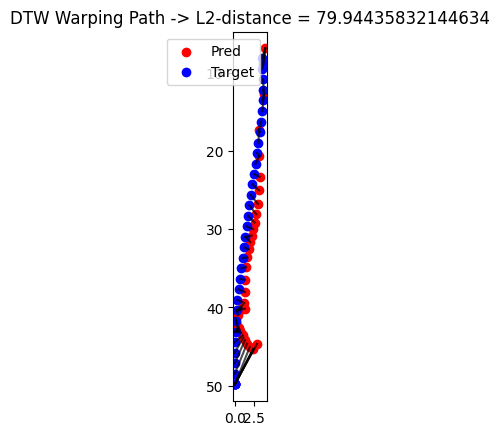

   Batch: 0    | Width: 6   | Loss: 7.1842
   Batch: 100  | Width: 46  | Loss: 4.9950
   Batch: 200  | Width: 56  | Loss: 4.2278
   Batch: 300  | Width: 64  | Loss: 4.3103
   Batch: 400  | Width: 72  | Loss: 4.7636
   Batch: 500  | Width: 78  | Loss: 5.0058
   Batch: 600  | Width: 84  | Loss: 4.1002
   Batch: 700  | Width: 90  | Loss: 4.8146
   Batch: 800  | Width: 96  | Loss: 5.4117

Epoch: 17 | Loss: 5.007672053436524


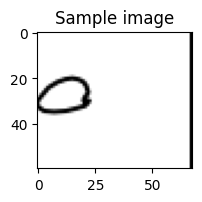

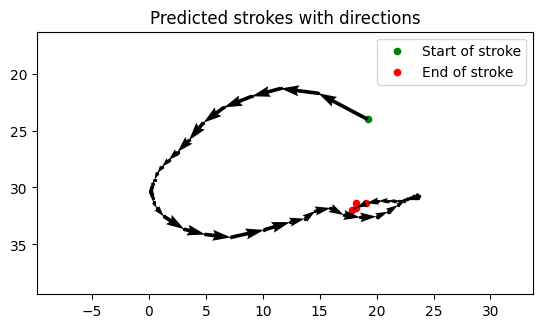

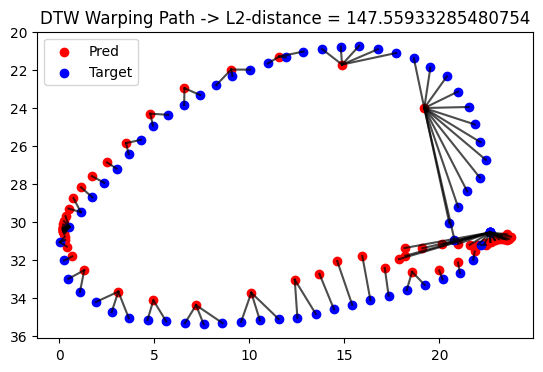

   Batch: 0    | Width: 6   | Loss: 7.2444
   Batch: 100  | Width: 46  | Loss: 5.0826
   Batch: 200  | Width: 56  | Loss: 4.1564
   Batch: 300  | Width: 64  | Loss: 3.8162
   Batch: 400  | Width: 72  | Loss: 4.7546
   Batch: 500  | Width: 78  | Loss: 4.9161
   Batch: 600  | Width: 84  | Loss: 3.8841
   Batch: 700  | Width: 90  | Loss: 4.5940
   Batch: 800  | Width: 96  | Loss: 5.4162

Epoch: 18 | Loss: 4.541454190256389


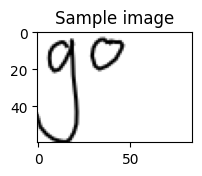

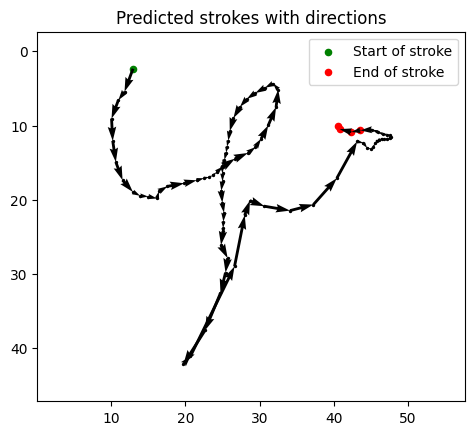

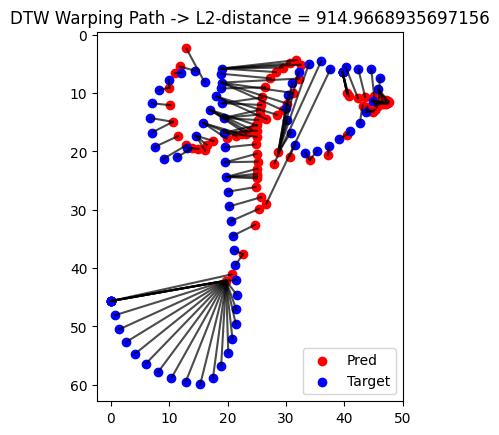

   Batch: 0    | Width: 6   | Loss: 7.2251
   Batch: 100  | Width: 46  | Loss: 4.7723
   Batch: 200  | Width: 56  | Loss: 4.1074
   Batch: 300  | Width: 64  | Loss: 3.6998
   Batch: 400  | Width: 72  | Loss: 4.4114
   Batch: 500  | Width: 78  | Loss: 4.5832
   Batch: 600  | Width: 84  | Loss: 4.1645
   Batch: 700  | Width: 90  | Loss: 4.8699
   Batch: 800  | Width: 96  | Loss: 5.4281

Epoch: 19 | Loss: 5.305384450477265


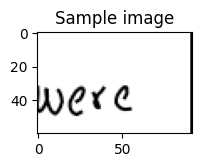

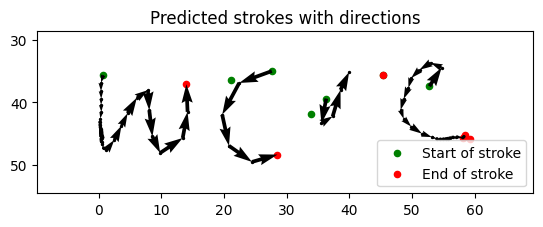

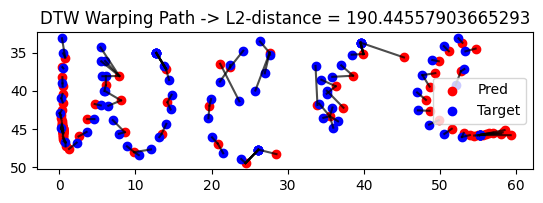

   Batch: 0    | Width: 6   | Loss: 7.3332
   Batch: 100  | Width: 46  | Loss: 4.9123
   Batch: 200  | Width: 56  | Loss: 3.9834
   Batch: 300  | Width: 64  | Loss: 3.9089
   Batch: 400  | Width: 72  | Loss: 4.6593
   Batch: 500  | Width: 78  | Loss: 4.4996
   Batch: 600  | Width: 84  | Loss: 3.9156
   Batch: 700  | Width: 90  | Loss: 4.3815
   Batch: 800  | Width: 96  | Loss: 4.8581

Epoch: 20 | Loss: 4.429112324003263


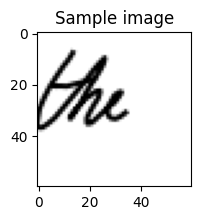

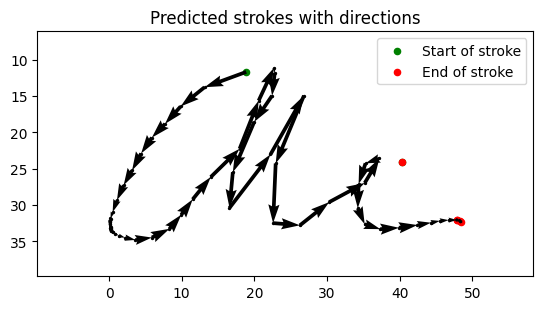

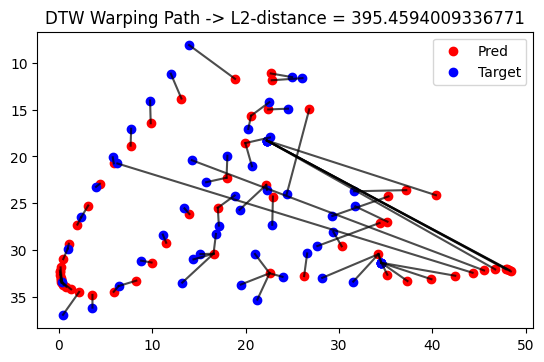

   Batch: 0    | Width: 6   | Loss: 6.9480
   Batch: 100  | Width: 46  | Loss: 4.6195
   Batch: 200  | Width: 56  | Loss: 3.8522
   Batch: 300  | Width: 64  | Loss: 4.1848
   Batch: 400  | Width: 72  | Loss: 4.6296
   Batch: 500  | Width: 78  | Loss: 4.4238
   Batch: 600  | Width: 84  | Loss: 3.7211
   Batch: 700  | Width: 90  | Loss: 4.3080
   Batch: 800  | Width: 96  | Loss: 5.1548

Epoch: 21 | Loss: 4.223014763663047


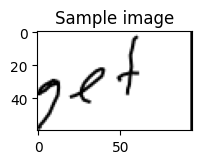

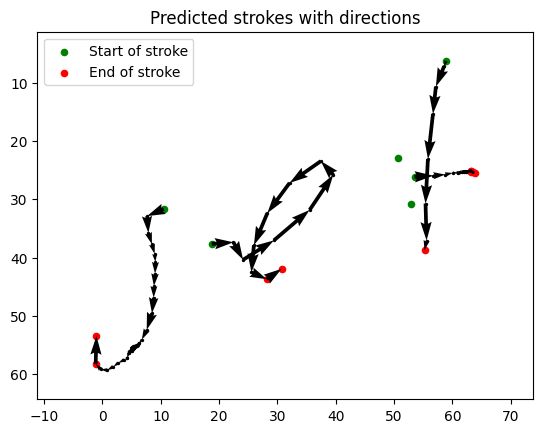

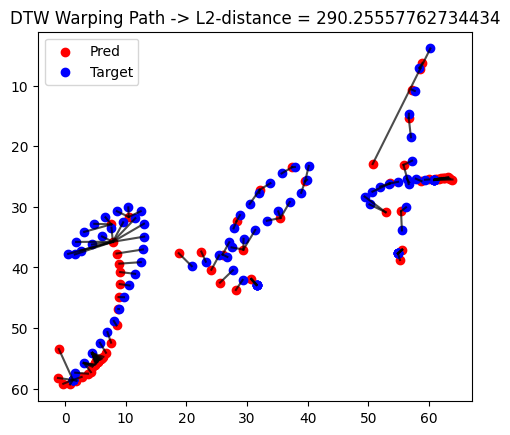

   Batch: 0    | Width: 6   | Loss: 7.4276
   Batch: 100  | Width: 46  | Loss: 4.6232
   Batch: 200  | Width: 56  | Loss: 3.9150
   Batch: 300  | Width: 64  | Loss: 3.6999
   Batch: 400  | Width: 72  | Loss: 4.5674
   Batch: 500  | Width: 78  | Loss: 4.3251
   Batch: 600  | Width: 84  | Loss: 3.7382
   Batch: 700  | Width: 90  | Loss: 4.1631
   Batch: 800  | Width: 96  | Loss: 4.9868

Epoch: 22 | Loss: 4.225457638502599


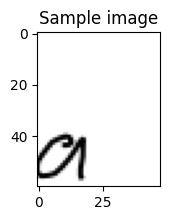

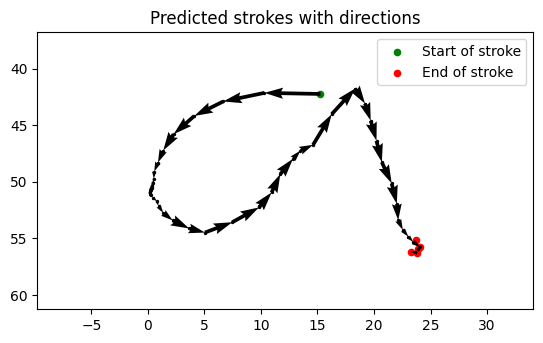

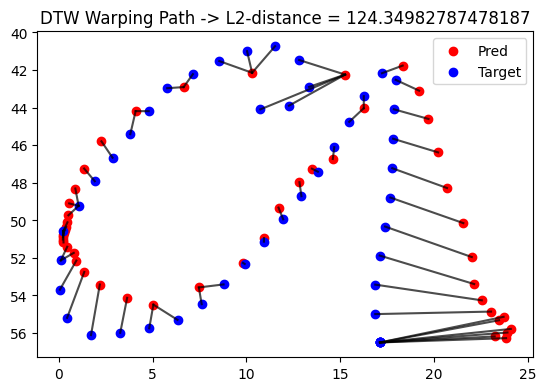

   Batch: 0    | Width: 6   | Loss: 6.9739
   Batch: 100  | Width: 46  | Loss: 4.4451
   Batch: 200  | Width: 56  | Loss: 3.7825
   Batch: 300  | Width: 64  | Loss: 3.4947
   Batch: 400  | Width: 72  | Loss: 4.3373
   Batch: 500  | Width: 78  | Loss: 4.6898
   Batch: 600  | Width: 84  | Loss: 3.6509
   Batch: 700  | Width: 90  | Loss: 4.0126
   Batch: 800  | Width: 96  | Loss: 4.8858

Epoch: 23 | Loss: 4.169025663570065


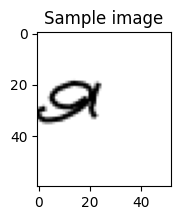

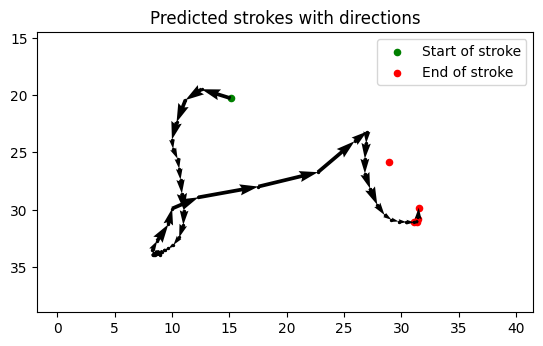

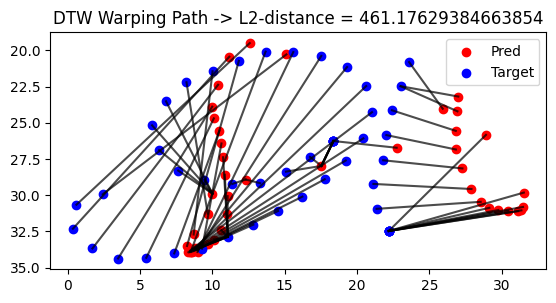

   Batch: 0    | Width: 6   | Loss: 6.8420
   Batch: 100  | Width: 46  | Loss: 4.5255
   Batch: 200  | Width: 56  | Loss: 3.8376
   Batch: 300  | Width: 64  | Loss: 3.8293
   Batch: 400  | Width: 72  | Loss: 4.2709
   Batch: 500  | Width: 78  | Loss: 4.1231
   Batch: 600  | Width: 84  | Loss: 3.3454
   Batch: 700  | Width: 90  | Loss: 4.1055
   Batch: 800  | Width: 96  | Loss: 4.7637

Epoch: 24 | Loss: 4.3867244640750584


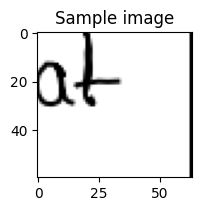

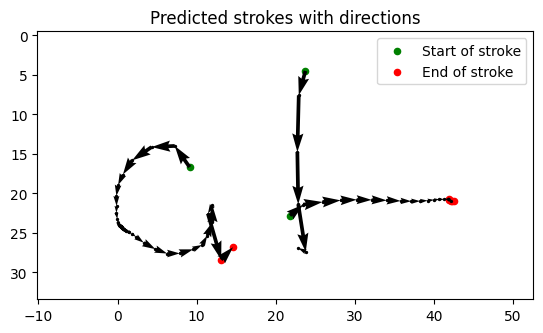

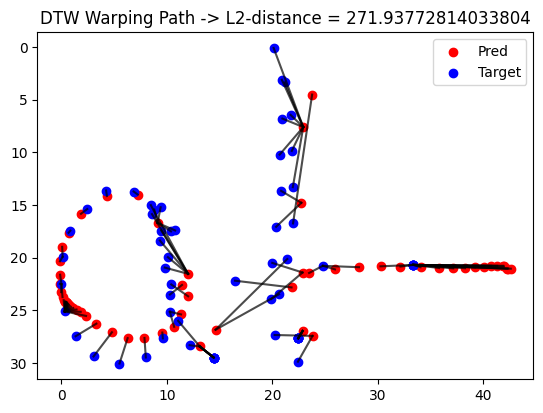

   Batch: 0    | Width: 6   | Loss: 6.2255
   Batch: 100  | Width: 46  | Loss: 4.2996
   Batch: 200  | Width: 56  | Loss: 3.7544
   Batch: 300  | Width: 64  | Loss: 3.3966
   Batch: 400  | Width: 72  | Loss: 4.2457
   Batch: 500  | Width: 78  | Loss: 4.6947
   Batch: 600  | Width: 84  | Loss: 3.7225
   Batch: 700  | Width: 90  | Loss: 4.0025
   Batch: 800  | Width: 96  | Loss: 4.9303

Epoch: 25 | Loss: 4.325409502644176


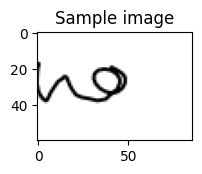

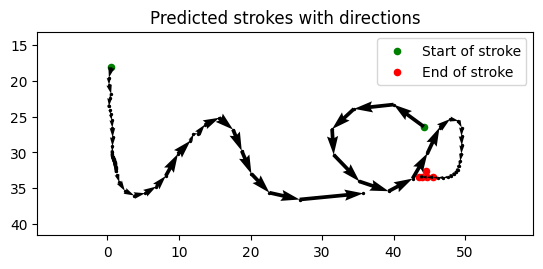

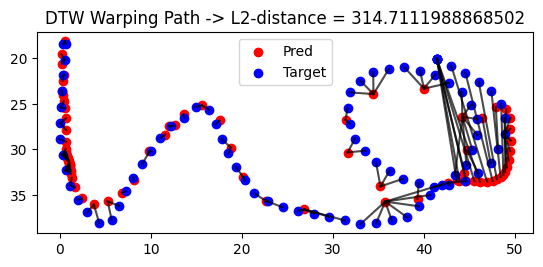

   Batch: 0    | Width: 6   | Loss: 6.3221
   Batch: 100  | Width: 46  | Loss: 4.3318
   Batch: 200  | Width: 56  | Loss: 3.5265
   Batch: 300  | Width: 64  | Loss: 3.7116
   Batch: 400  | Width: 72  | Loss: 4.2359
   Batch: 500  | Width: 78  | Loss: 4.4325
   Batch: 600  | Width: 84  | Loss: 3.4102
   Batch: 700  | Width: 90  | Loss: 3.8273
   Batch: 800  | Width: 96  | Loss: 4.6924

Epoch: 26 | Loss: 3.8380598259294176


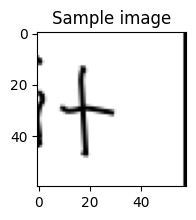

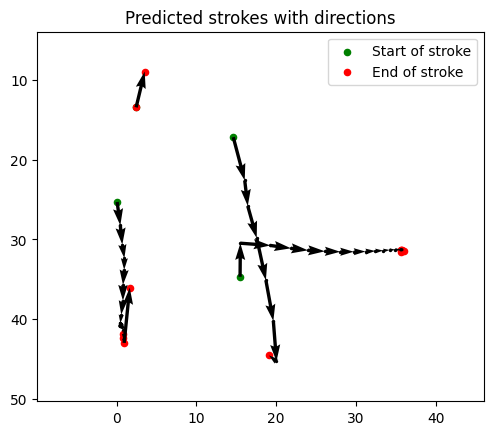

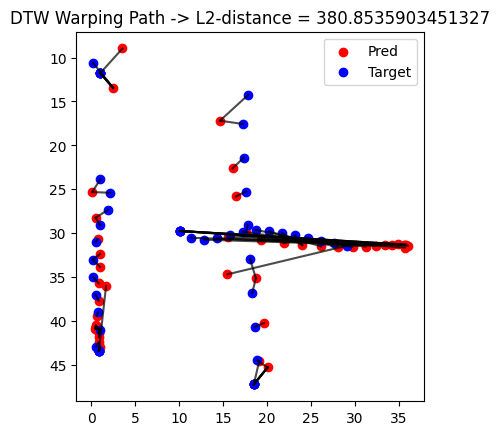

   Batch: 0    | Width: 6   | Loss: 6.1807
   Batch: 100  | Width: 46  | Loss: 4.2319
   Batch: 200  | Width: 56  | Loss: 3.4513
   Batch: 300  | Width: 64  | Loss: 3.3033
   Batch: 400  | Width: 72  | Loss: 4.0890
   Batch: 500  | Width: 78  | Loss: 4.1185
   Batch: 600  | Width: 84  | Loss: 3.4337
   Batch: 700  | Width: 90  | Loss: 3.8729
   Batch: 800  | Width: 96  | Loss: 4.2114

Epoch: 27 | Loss: 4.100059259354374


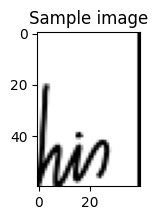

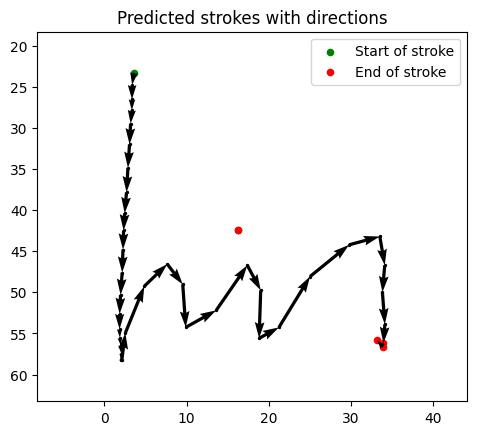

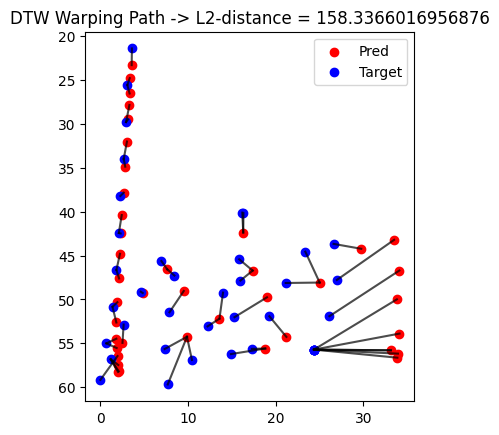

   Batch: 0    | Width: 6   | Loss: 6.4739
   Batch: 100  | Width: 46  | Loss: 4.2556
   Batch: 200  | Width: 56  | Loss: 3.5014
   Batch: 300  | Width: 64  | Loss: 3.3670
   Batch: 400  | Width: 72  | Loss: 3.9695
   Batch: 500  | Width: 78  | Loss: 3.9403
   Batch: 600  | Width: 84  | Loss: 3.2067
   Batch: 700  | Width: 90  | Loss: 3.7438
   Batch: 800  | Width: 96  | Loss: 4.2004

Epoch: 28 | Loss: 3.8410594882099116


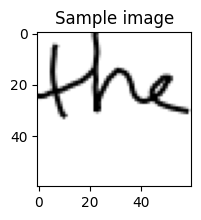

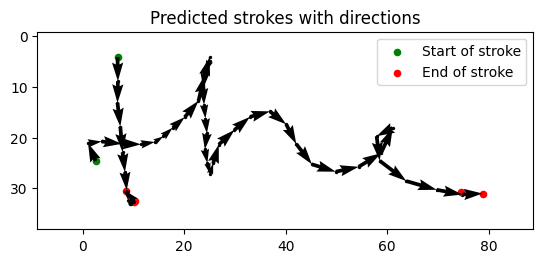

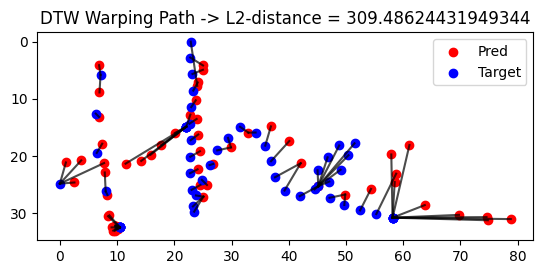

   Batch: 0    | Width: 6   | Loss: 6.3211
   Batch: 100  | Width: 46  | Loss: 4.2127
   Batch: 200  | Width: 56  | Loss: 3.3909
   Batch: 300  | Width: 64  | Loss: 3.2984
   Batch: 400  | Width: 72  | Loss: 4.0380
   Batch: 500  | Width: 78  | Loss: 3.9432
   Batch: 600  | Width: 84  | Loss: 3.3236
   Batch: 700  | Width: 90  | Loss: 3.7952
   Batch: 800  | Width: 96  | Loss: 4.4578

Epoch: 29 | Loss: 3.7650649740538835


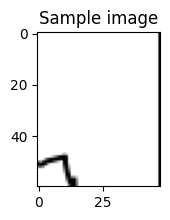

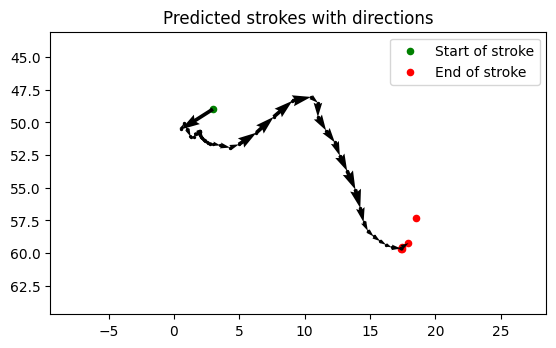

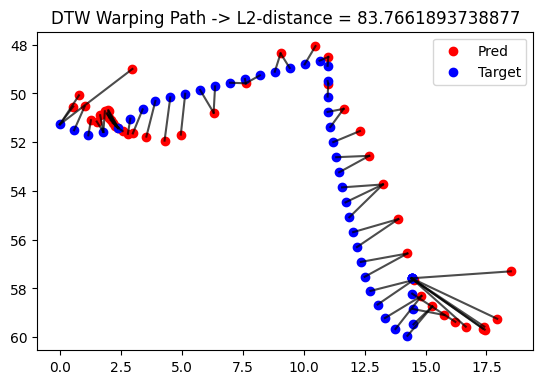

   Batch: 0    | Width: 6   | Loss: 6.1762
   Batch: 100  | Width: 46  | Loss: 4.0519
   Batch: 200  | Width: 56  | Loss: 3.3942
   Batch: 300  | Width: 64  | Loss: 3.2900
   Batch: 400  | Width: 72  | Loss: 3.9537
   Batch: 500  | Width: 78  | Loss: 3.7000
   Batch: 600  | Width: 84  | Loss: 3.2306
   Batch: 700  | Width: 90  | Loss: 3.6254
   Batch: 800  | Width: 96  | Loss: 4.3948

Epoch: 30 | Loss: 3.809495432658183


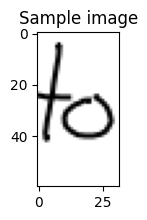

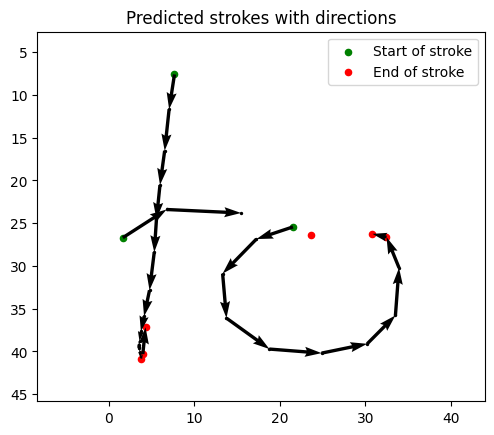

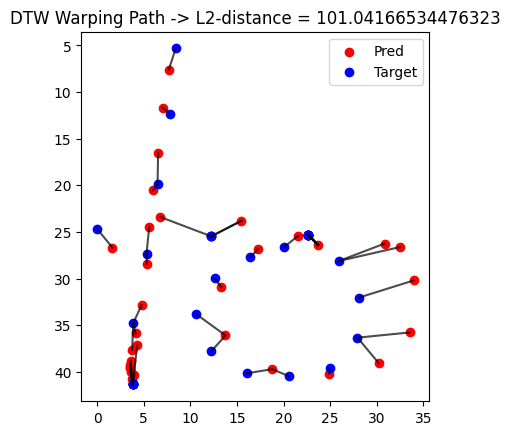

   Batch: 0    | Width: 6   | Loss: 6.3653
   Batch: 100  | Width: 46  | Loss: 3.9526
   Batch: 600  | Width: 84  | Loss: 3.1262
   Batch: 700  | Width: 90  | Loss: 3.6230
   Batch: 800  | Width: 96  | Loss: 4.3340

Epoch: 31 | Loss: 3.842505234737843


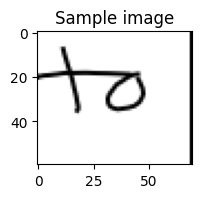

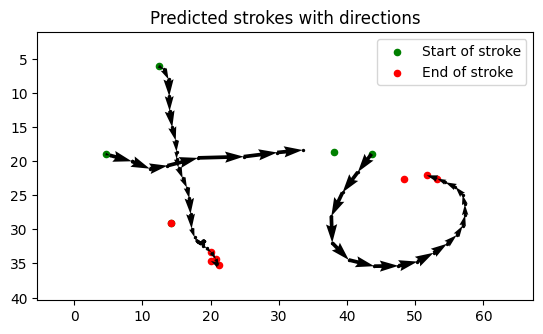

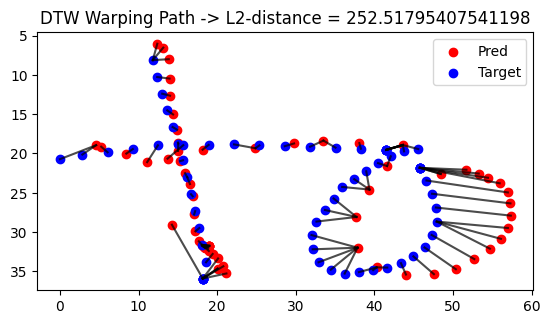

   Batch: 0    | Width: 6   | Loss: 6.5752
   Batch: 100  | Width: 46  | Loss: 3.8877
   Batch: 200  | Width: 56  | Loss: 3.3878
   Batch: 300  | Width: 64  | Loss: 3.2420
   Batch: 400  | Width: 72  | Loss: 3.8144
   Batch: 500  | Width: 78  | Loss: 3.9060
   Batch: 600  | Width: 84  | Loss: 3.1667
   Batch: 700  | Width: 90  | Loss: 3.6455
   Batch: 800  | Width: 96  | Loss: 4.1592

Epoch: 32 | Loss: 3.7455648368606633


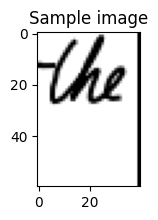

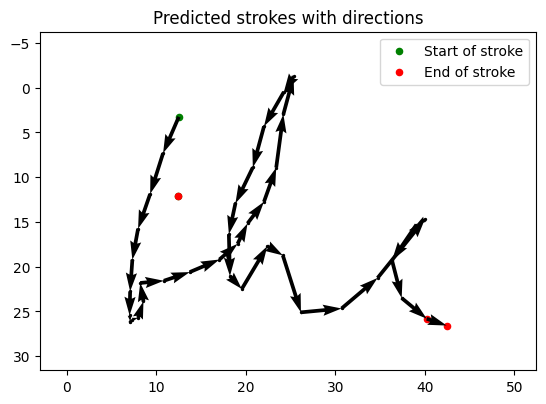

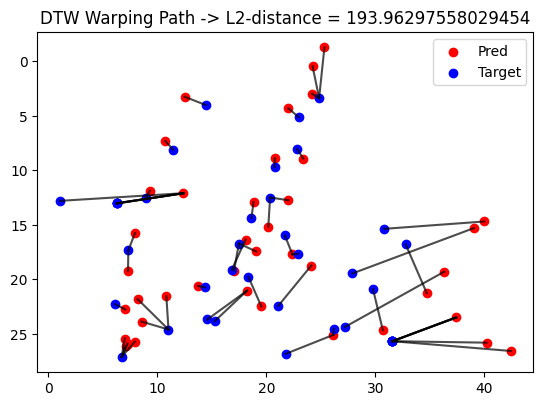

   Batch: 0    | Width: 6   | Loss: 6.7673
   Batch: 100  | Width: 46  | Loss: 3.7673
   Batch: 200  | Width: 56  | Loss: 3.2385
   Batch: 300  | Width: 64  | Loss: 3.1275
   Batch: 400  | Width: 72  | Loss: 3.9040
   Batch: 500  | Width: 78  | Loss: 3.4251
   Batch: 600  | Width: 84  | Loss: 3.0996
   Batch: 700  | Width: 90  | Loss: 3.6435
   Batch: 800  | Width: 96  | Loss: 3.9880

Epoch: 33 | Loss: 3.6899980547115843


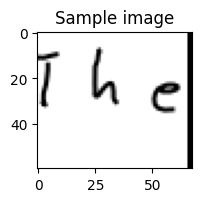

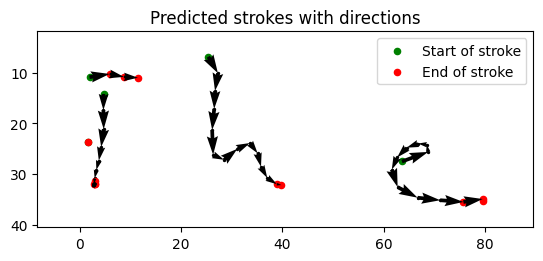

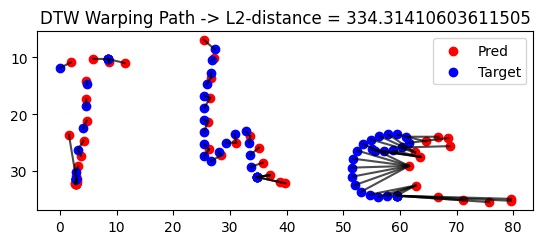

   Batch: 0    | Width: 6   | Loss: 6.5179
   Batch: 100  | Width: 46  | Loss: 3.9132
   Batch: 200  | Width: 56  | Loss: 3.3138
   Batch: 300  | Width: 64  | Loss: 3.1146
   Batch: 400  | Width: 72  | Loss: 3.8129
   Batch: 500  | Width: 78  | Loss: 3.7021
   Batch: 600  | Width: 84  | Loss: 3.0844
   Batch: 700  | Width: 90  | Loss: 3.6086
   Batch: 800  | Width: 96  | Loss: 4.2040

Epoch: 34 | Loss: 3.6951008986753138


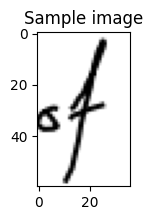

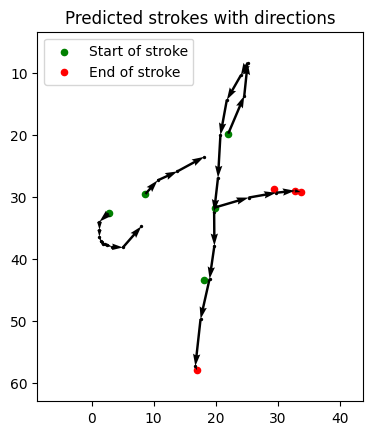

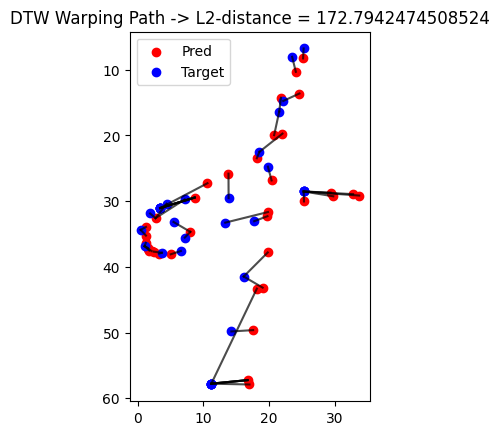

   Batch: 0    | Width: 6   | Loss: 5.8992
   Batch: 100  | Width: 46  | Loss: 3.7288
   Batch: 200  | Width: 56  | Loss: 3.1058
   Batch: 300  | Width: 64  | Loss: 2.9881
   Batch: 400  | Width: 72  | Loss: 3.6611
   Batch: 500  | Width: 78  | Loss: 3.5214
   Batch: 600  | Width: 84  | Loss: 3.0474
   Batch: 700  | Width: 90  | Loss: 3.6366
   Batch: 800  | Width: 96  | Loss: 4.0604

Epoch: 35 | Loss: 3.7911767760054222


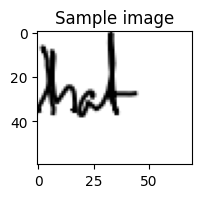

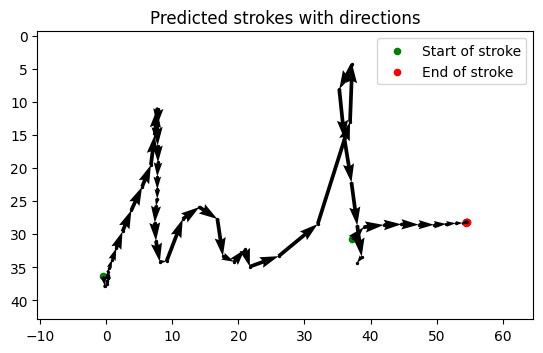

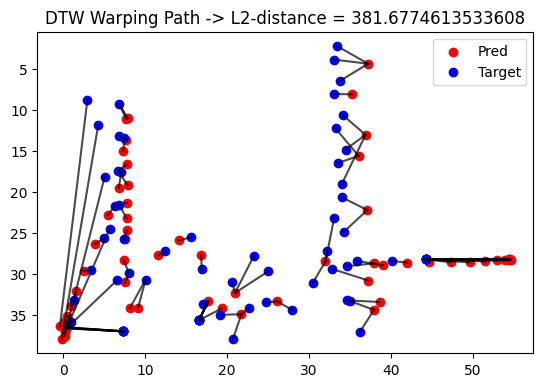

   Batch: 0    | Width: 6   | Loss: 6.4821
   Batch: 100  | Width: 46  | Loss: 3.5568
   Batch: 200  | Width: 56  | Loss: 3.1148
   Batch: 300  | Width: 64  | Loss: 2.9609
   Batch: 400  | Width: 72  | Loss: 3.6911
   Batch: 500  | Width: 78  | Loss: 3.3980
   Batch: 600  | Width: 84  | Loss: 2.9169
   Batch: 700  | Width: 90  | Loss: 3.4977
   Batch: 800  | Width: 96  | Loss: 4.1004

Epoch: 36 | Loss: 3.483705628482133


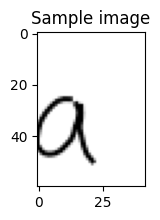

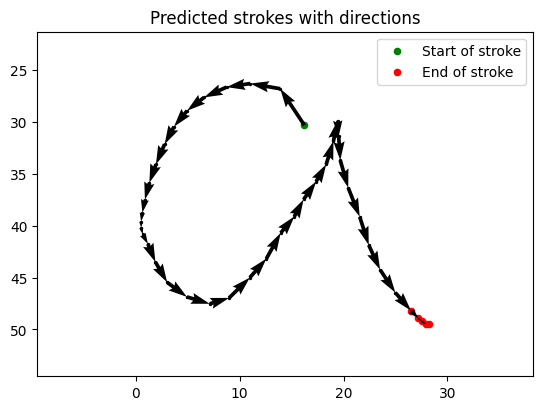

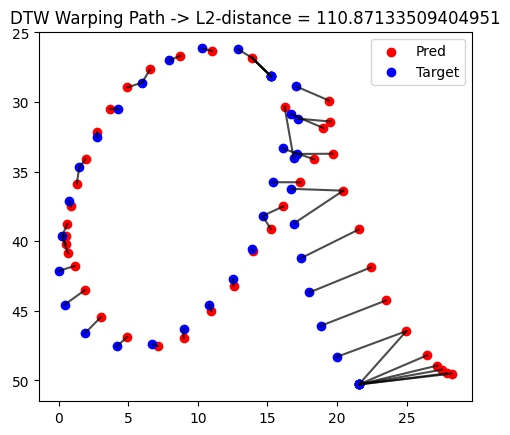

   Batch: 0    | Width: 6   | Loss: 5.8634
   Batch: 100  | Width: 46  | Loss: 3.6395
   Batch: 200  | Width: 56  | Loss: 3.0364
   Batch: 300  | Width: 64  | Loss: 3.0508
   Batch: 400  | Width: 72  | Loss: 3.6420
   Batch: 500  | Width: 78  | Loss: 3.3026
   Batch: 600  | Width: 84  | Loss: 2.9262
   Batch: 700  | Width: 90  | Loss: 3.4126
   Batch: 800  | Width: 96  | Loss: 3.9393

Epoch: 37 | Loss: 3.6138572488200227


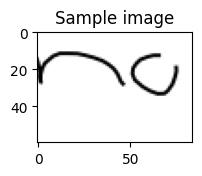

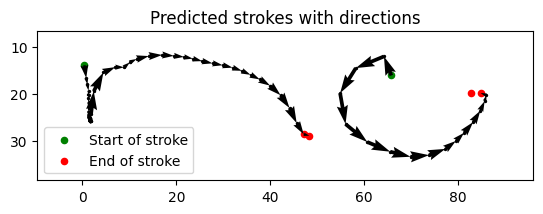

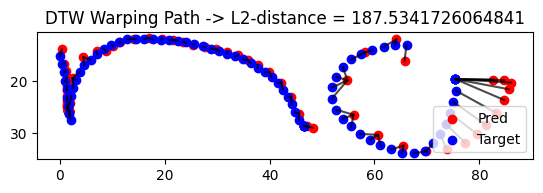

   Batch: 0    | Width: 6   | Loss: 6.2659
   Batch: 100  | Width: 46  | Loss: 3.5998
   Batch: 200  | Width: 56  | Loss: 3.0002
   Batch: 300  | Width: 64  | Loss: 2.9533
   Batch: 400  | Width: 72  | Loss: 3.5980
   Batch: 500  | Width: 78  | Loss: 3.4629
   Batch: 600  | Width: 84  | Loss: 2.9773
   Batch: 700  | Width: 90  | Loss: 3.3422
   Batch: 800  | Width: 96  | Loss: 3.7080

Epoch: 38 | Loss: 3.7043365860947834


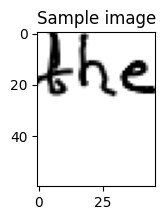

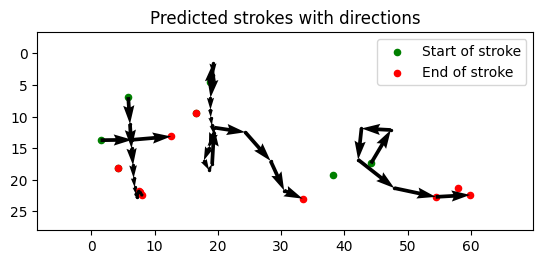

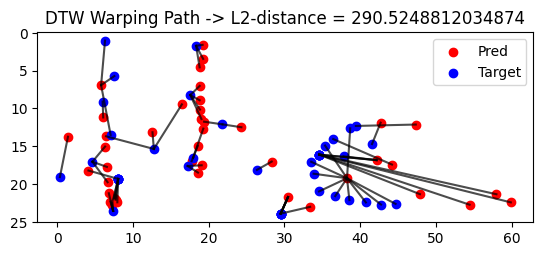

   Batch: 0    | Width: 6   | Loss: 6.1808
   Batch: 100  | Width: 46  | Loss: 3.6556
   Batch: 200  | Width: 56  | Loss: 3.1861
   Batch: 300  | Width: 64  | Loss: 2.9957
   Batch: 400  | Width: 72  | Loss: 3.6505
   Batch: 500  | Width: 78  | Loss: 3.1078
   Batch: 600  | Width: 84  | Loss: 2.9159
   Batch: 700  | Width: 90  | Loss: 3.3014
   Batch: 800  | Width: 96  | Loss: 3.8910

Epoch: 39 | Loss: 3.594094162624429


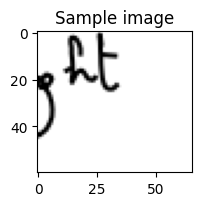

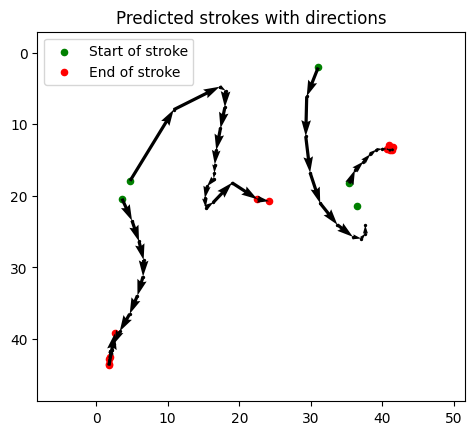

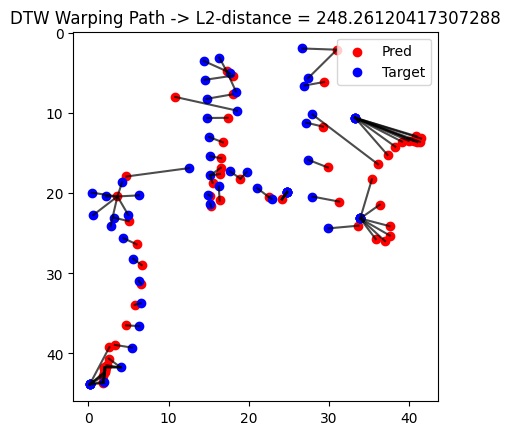

   Batch: 0    | Width: 6   | Loss: 6.5921
   Batch: 100  | Width: 46  | Loss: 3.5079
   Batch: 200  | Width: 56  | Loss: 3.0094
   Batch: 300  | Width: 64  | Loss: 2.8385
   Batch: 400  | Width: 72  | Loss: 3.6591
   Batch: 500  | Width: 78  | Loss: 3.2088
   Batch: 600  | Width: 84  | Loss: 2.8063
   Batch: 700  | Width: 90  | Loss: 3.2623
   Batch: 800  | Width: 96  | Loss: 3.8041

Epoch: 40 | Loss: 3.572730198253791


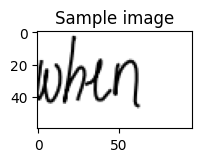

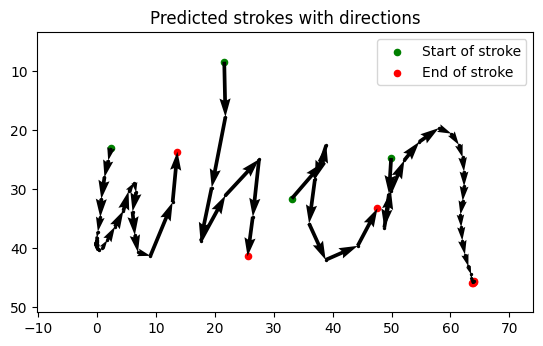

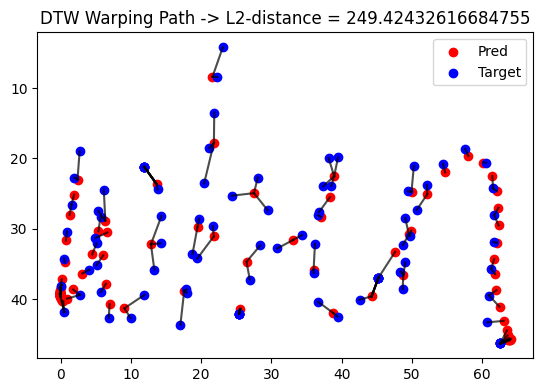

   Batch: 0    | Width: 6   | Loss: 6.2088
   Batch: 100  | Width: 46  | Loss: 3.2564
   Batch: 200  | Width: 56  | Loss: 2.8695
   Batch: 300  | Width: 64  | Loss: 3.0597
   Batch: 400  | Width: 72  | Loss: 3.6850
   Batch: 500  | Width: 78  | Loss: 3.2483
   Batch: 600  | Width: 84  | Loss: 2.9100
   Batch: 700  | Width: 90  | Loss: 3.1625
   Batch: 800  | Width: 96  | Loss: 3.8535


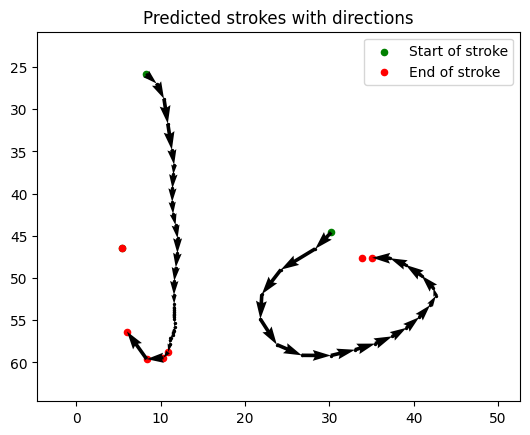

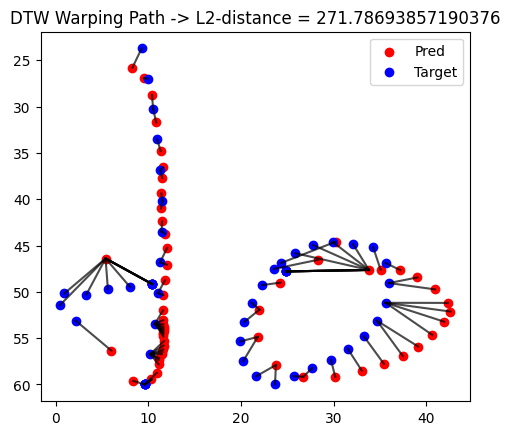

   Batch: 0    | Width: 6   | Loss: 6.1138
   Batch: 100  | Width: 46  | Loss: 3.4616
   Batch: 200  | Width: 56  | Loss: 2.9261
   Batch: 300  | Width: 64  | Loss: 2.9713
   Batch: 400  | Width: 72  | Loss: 3.6762
   Batch: 500  | Width: 78  | Loss: 2.9180
   Batch: 600  | Width: 84  | Loss: 2.8417
   Batch: 700  | Width: 90  | Loss: 3.3275
   Batch: 800  | Width: 96  | Loss: 3.7358

Epoch: 42 | Loss: 3.4037787888378093


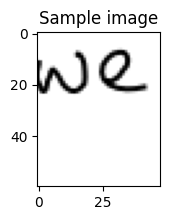

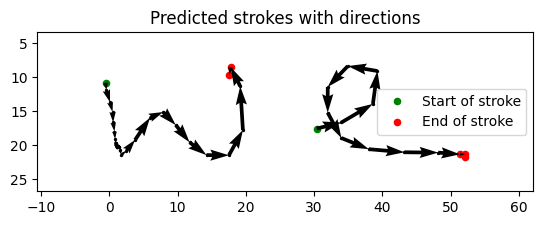

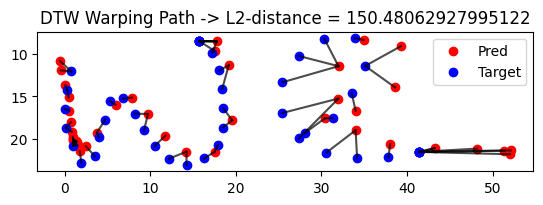

   Batch: 0    | Width: 6   | Loss: 5.8702
   Batch: 100  | Width: 46  | Loss: 3.5025
   Batch: 300  | Width: 64  | Loss: 3.1427
   Batch: 400  | Width: 72  | Loss: 3.8428
   Batch: 500  | Width: 78  | Loss: 3.2905
   Batch: 600  | Width: 84  | Loss: 3.0139
   Batch: 700  | Width: 90  | Loss: 3.1441
   Batch: 800  | Width: 96  | Loss: 3.7858

Epoch: 43 | Loss: 3.3734402835013846


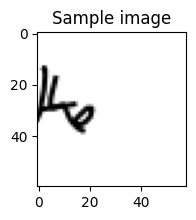

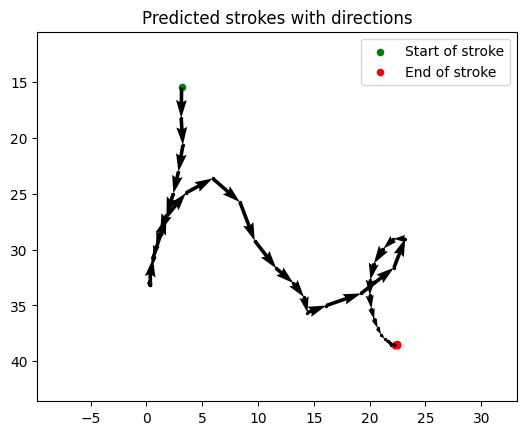

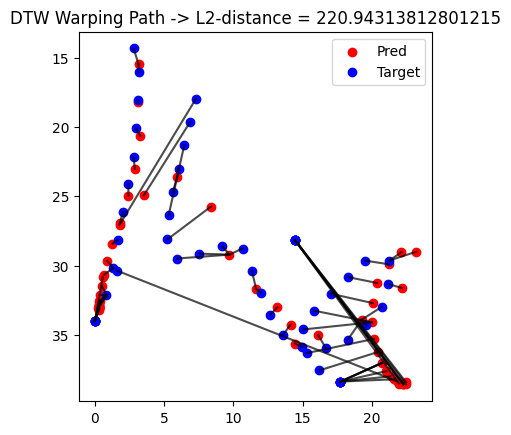

   Batch: 0    | Width: 6   | Loss: 5.9565
   Batch: 100  | Width: 46  | Loss: 3.4767
   Batch: 200  | Width: 56  | Loss: 2.9598
   Batch: 300  | Width: 64  | Loss: 2.9377
   Batch: 500  | Width: 78  | Loss: 2.8153
   Batch: 600  | Width: 84  | Loss: 2.8370
   Batch: 700  | Width: 90  | Loss: 3.2245
   Batch: 800  | Width: 96  | Loss: 3.7149

Epoch: 44 | Loss: 3.4597899352686228


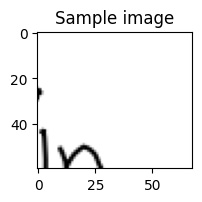

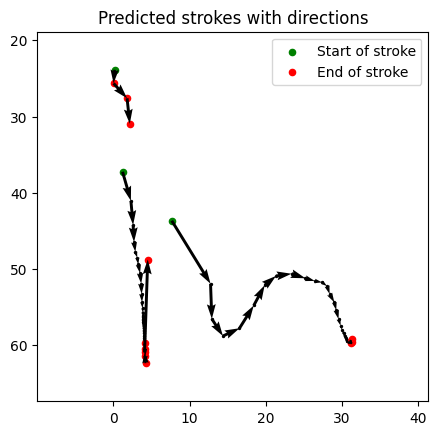

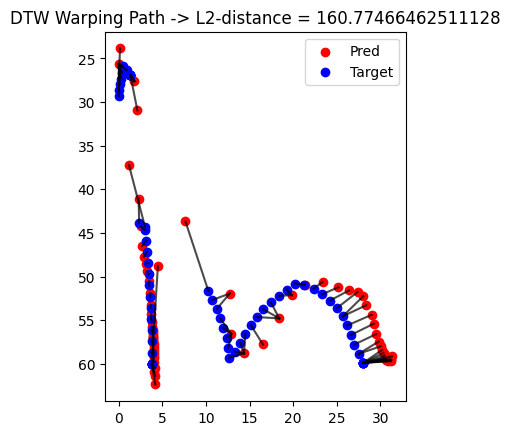

   Batch: 0    | Width: 6   | Loss: 5.9001
   Batch: 100  | Width: 46  | Loss: 3.4280
   Batch: 200  | Width: 56  | Loss: 3.0313
   Batch: 300  | Width: 64  | Loss: 3.0253
   Batch: 400  | Width: 72  | Loss: 3.7423
   Batch: 500  | Width: 78  | Loss: 2.9833
   Batch: 600  | Width: 84  | Loss: 2.9212
   Batch: 700  | Width: 90  | Loss: 3.0593
   Batch: 800  | Width: 96  | Loss: 3.6442

Epoch: 45 | Loss: 3.4052292600024323


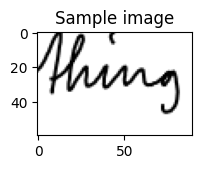

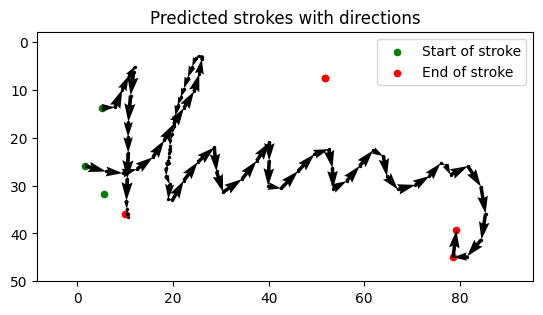

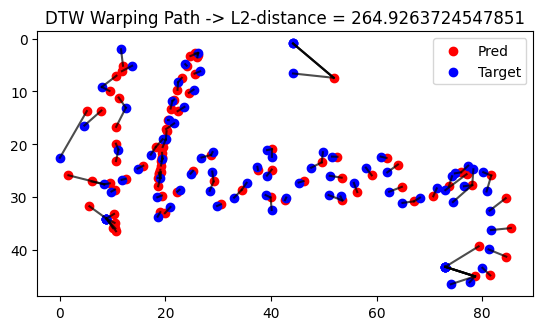

   Batch: 0    | Width: 6   | Loss: 5.3802
   Batch: 100  | Width: 46  | Loss: 3.3362
   Batch: 200  | Width: 56  | Loss: 2.9761
   Batch: 300  | Width: 64  | Loss: 2.9809
   Batch: 400  | Width: 72  | Loss: 3.4760
   Batch: 500  | Width: 78  | Loss: 2.7383
   Batch: 600  | Width: 84  | Loss: 2.5910
   Batch: 800  | Width: 96  | Loss: 3.6526

Epoch: 46 | Loss: 3.3016901538226713


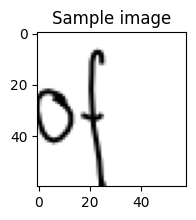

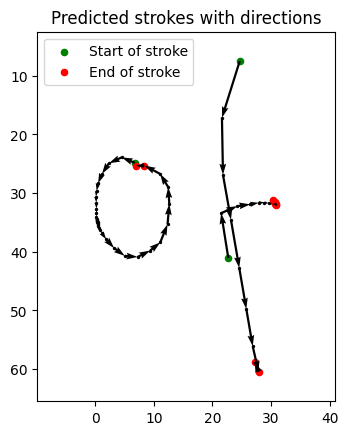

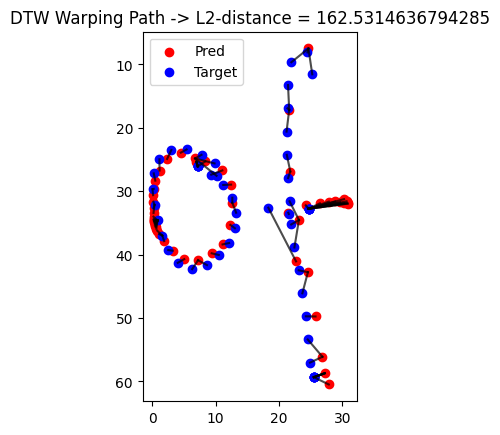

   Batch: 0    | Width: 6   | Loss: 5.8061
   Batch: 100  | Width: 46  | Loss: 3.3708
   Batch: 200  | Width: 56  | Loss: 2.8017
   Batch: 300  | Width: 64  | Loss: 3.0344
   Batch: 400  | Width: 72  | Loss: 3.3824
   Batch: 500  | Width: 78  | Loss: 2.7455
   Batch: 600  | Width: 84  | Loss: 2.6719
   Batch: 700  | Width: 90  | Loss: 3.3235
   Batch: 800  | Width: 96  | Loss: 3.6041

Epoch: 47 | Loss: 3.4065066530614514


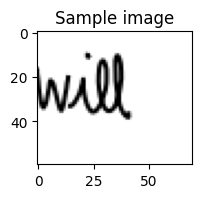

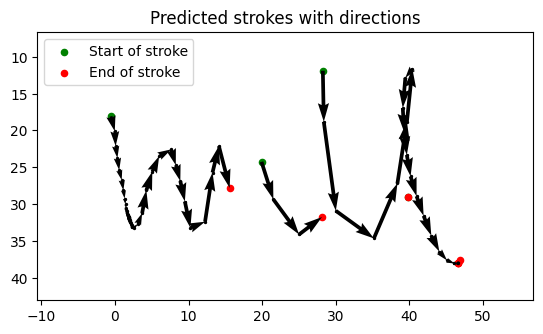

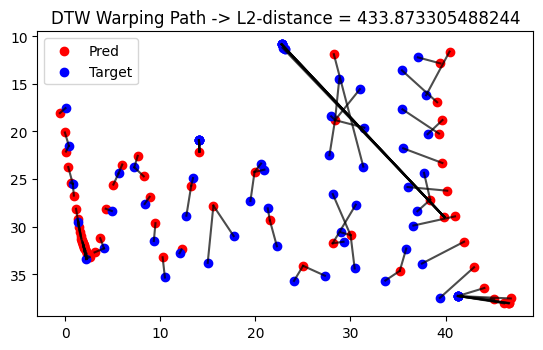

   Batch: 0    | Width: 6   | Loss: 5.9770
   Batch: 100  | Width: 46  | Loss: 3.2067
   Batch: 200  | Width: 56  | Loss: 2.8984
   Batch: 300  | Width: 64  | Loss: 2.9409
   Batch: 400  | Width: 72  | Loss: 3.2760
   Batch: 500  | Width: 78  | Loss: 2.8200
   Batch: 600  | Width: 84  | Loss: 2.7958
   Batch: 700  | Width: 90  | Loss: 3.1082
   Batch: 800  | Width: 96  | Loss: 3.7859

Epoch: 48 | Loss: 3.385590960007936


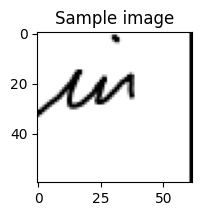

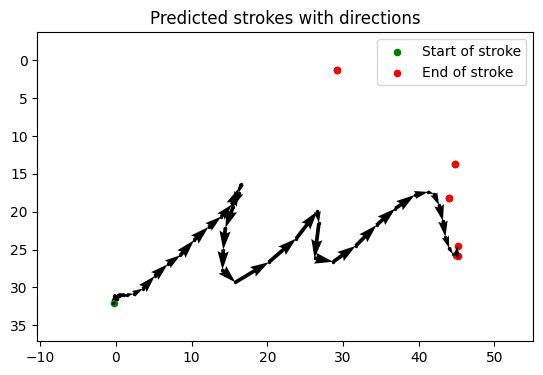

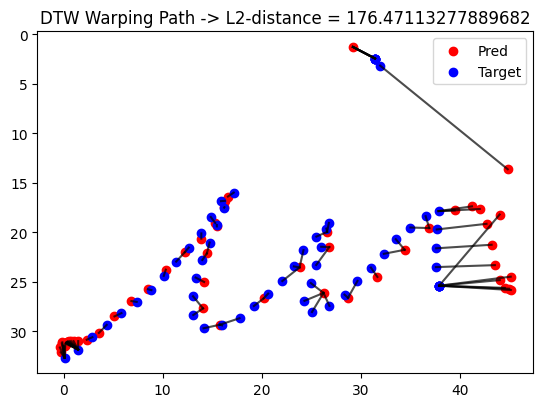

   Batch: 0    | Width: 6   | Loss: 5.6579
   Batch: 100  | Width: 46  | Loss: 3.1860
   Batch: 200  | Width: 56  | Loss: 2.8484
   Batch: 300  | Width: 64  | Loss: 3.0806
   Batch: 400  | Width: 72  | Loss: 3.3321
   Batch: 500  | Width: 78  | Loss: 2.8066
   Batch: 600  | Width: 84  | Loss: 2.6956
   Batch: 700  | Width: 90  | Loss: 3.0983
   Batch: 800  | Width: 96  | Loss: 3.7133

Epoch: 49 | Loss: 3.2876133219876995


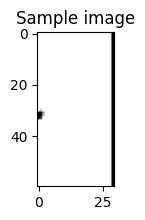

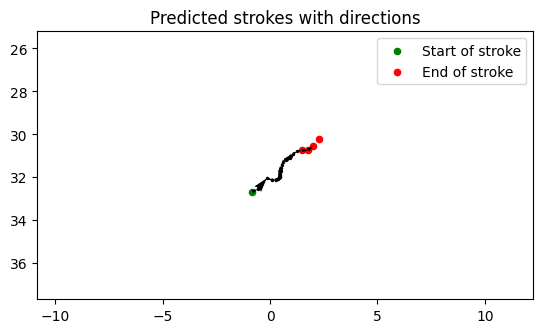

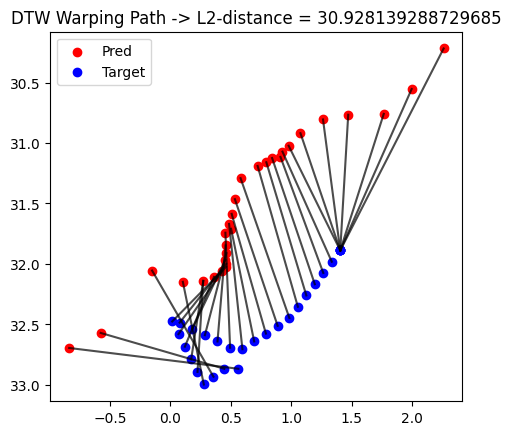

   Batch: 0    | Width: 6   | Loss: 5.9533
   Batch: 100  | Width: 46  | Loss: 3.2765
   Batch: 200  | Width: 56  | Loss: 2.8097
   Batch: 300  | Width: 64  | Loss: 2.7743
   Batch: 400  | Width: 72  | Loss: 3.2900
   Batch: 600  | Width: 84  | Loss: 2.6192
   Batch: 700  | Width: 90  | Loss: 3.0157
   Batch: 800  | Width: 96  | Loss: 3.6022

Epoch: 50 | Loss: 3.423820236198729


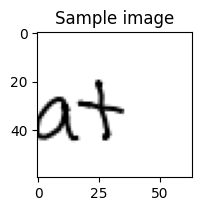

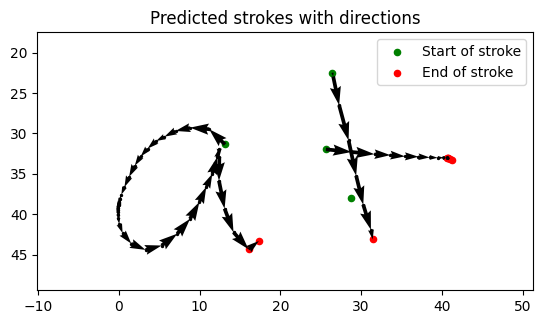

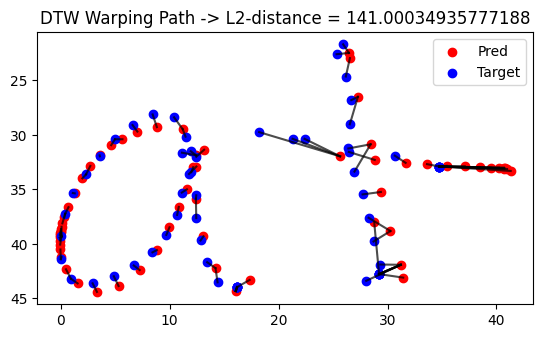

   Batch: 0    | Width: 6   | Loss: 5.4596
   Batch: 100  | Width: 46  | Loss: 3.2001
   Batch: 200  | Width: 56  | Loss: 2.6799
   Batch: 300  | Width: 64  | Loss: 2.8973
   Batch: 400  | Width: 72  | Loss: 3.1159
   Batch: 500  | Width: 78  | Loss: 2.6336
   Batch: 600  | Width: 84  | Loss: 2.4818
   Batch: 700  | Width: 90  | Loss: 2.9157
   Batch: 800  | Width: 96  | Loss: 3.5675

Epoch: 51 | Loss: 3.3986301412474162


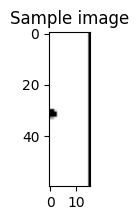

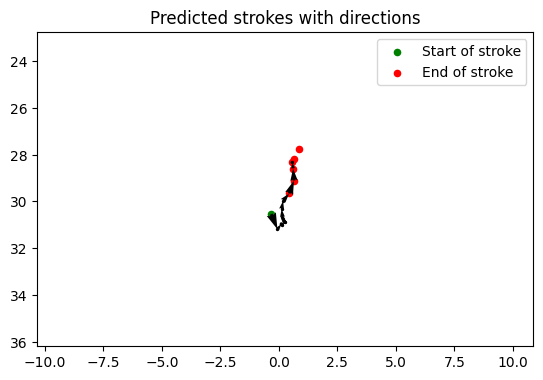

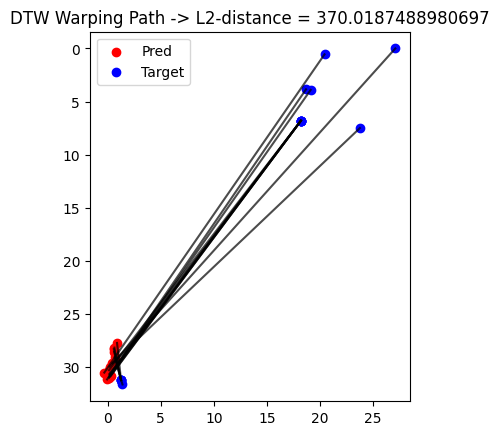

   Batch: 0    | Width: 6   | Loss: 6.0918
   Batch: 100  | Width: 46  | Loss: 3.1322
   Batch: 200  | Width: 56  | Loss: 2.8198
   Batch: 300  | Width: 64  | Loss: 2.8668
   Batch: 400  | Width: 72  | Loss: 3.2433
   Batch: 500  | Width: 78  | Loss: 2.7064
   Batch: 600  | Width: 84  | Loss: 2.4951
   Batch: 700  | Width: 90  | Loss: 2.9367
   Batch: 800  | Width: 96  | Loss: 3.4396

Epoch: 52 | Loss: 3.330106408709627


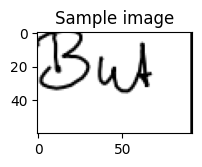

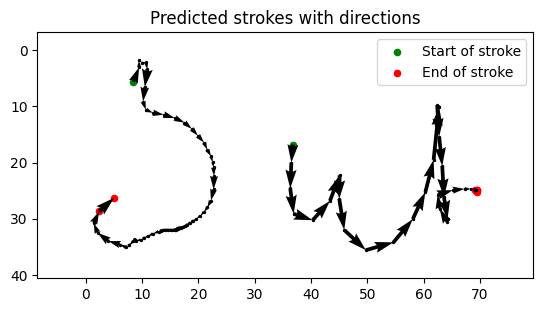

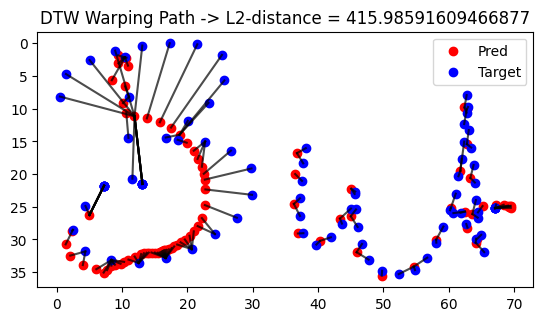

   Batch: 0    | Width: 6   | Loss: 5.5078
   Batch: 100  | Width: 46  | Loss: 3.1320
   Batch: 200  | Width: 56  | Loss: 2.6556
   Batch: 300  | Width: 64  | Loss: 2.8529
   Batch: 400  | Width: 72  | Loss: 3.3089
   Batch: 500  | Width: 78  | Loss: 2.5397
   Batch: 600  | Width: 84  | Loss: 2.6056
   Batch: 700  | Width: 90  | Loss: 2.8809
   Batch: 800  | Width: 96  | Loss: 3.4651

Epoch: 53 | Loss: 3.390911384177497


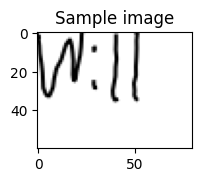

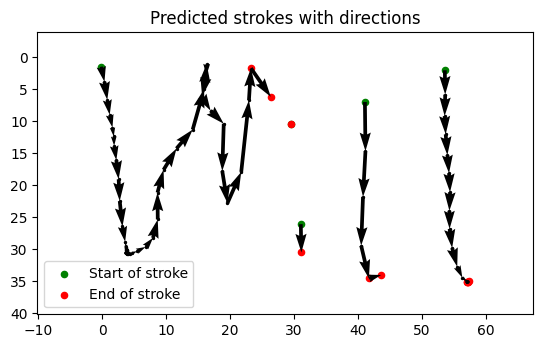

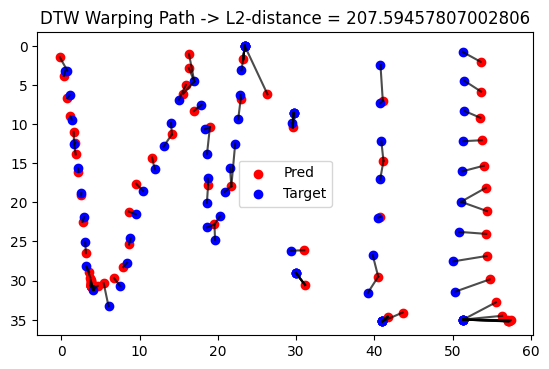

   Batch: 0    | Width: 6   | Loss: 5.7786
   Batch: 100  | Width: 46  | Loss: 3.0735
   Batch: 200  | Width: 56  | Loss: 2.8361
   Batch: 300  | Width: 64  | Loss: 3.0513
   Batch: 400  | Width: 72  | Loss: 3.1926
   Batch: 500  | Width: 78  | Loss: 2.5066
   Batch: 600  | Width: 84  | Loss: 2.7346
   Batch: 700  | Width: 90  | Loss: 2.9071
   Batch: 800  | Width: 96  | Loss: 3.4290

Epoch: 54 | Loss: 3.2570558531309475


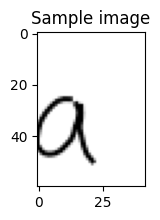

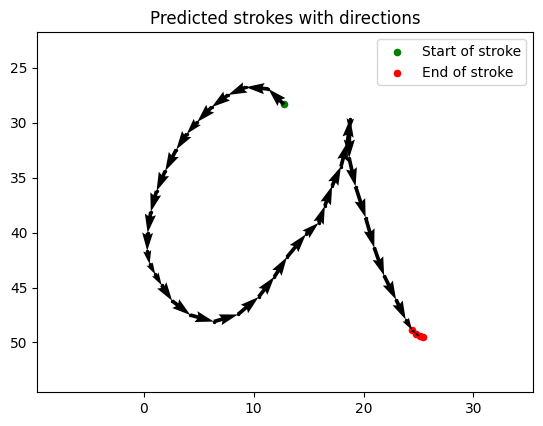

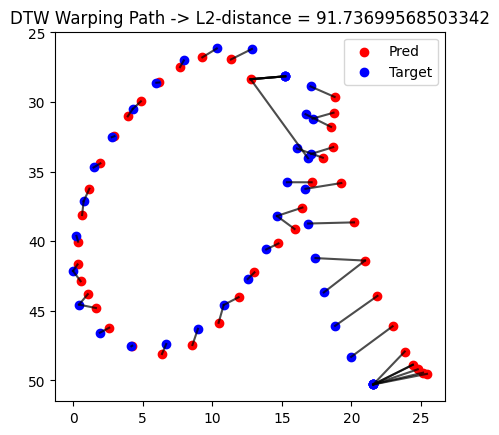

   Batch: 0    | Width: 6   | Loss: 5.5361
   Batch: 100  | Width: 46  | Loss: 3.0583
   Batch: 200  | Width: 56  | Loss: 2.7139
   Batch: 300  | Width: 64  | Loss: 2.7041
   Batch: 400  | Width: 72  | Loss: 3.2127
   Batch: 500  | Width: 78  | Loss: 2.4839
   Batch: 600  | Width: 84  | Loss: 2.5583
   Batch: 700  | Width: 90  | Loss: 3.1788
   Batch: 800  | Width: 96  | Loss: 3.4886

Epoch: 55 | Loss: 3.302000056121165


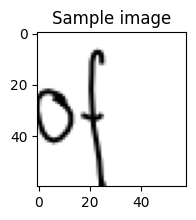

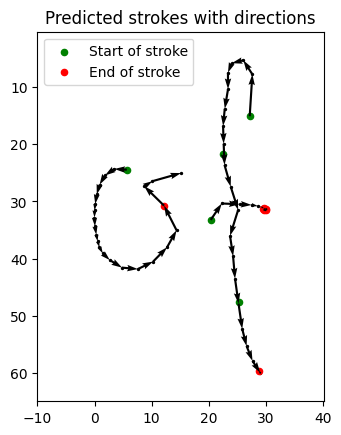

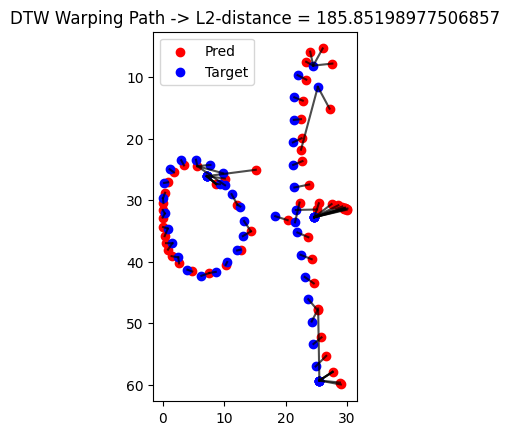

   Batch: 0    | Width: 6   | Loss: 6.1600
   Batch: 100  | Width: 46  | Loss: 3.0827
   Batch: 200  | Width: 56  | Loss: 2.7883
   Batch: 300  | Width: 64  | Loss: 2.9135
   Batch: 400  | Width: 72  | Loss: 3.2758
   Batch: 500  | Width: 78  | Loss: 2.5827
   Batch: 600  | Width: 84  | Loss: 2.5901
   Batch: 700  | Width: 90  | Loss: 2.9124
   Batch: 800  | Width: 96  | Loss: 3.3131

Epoch: 56 | Loss: 3.2196145909489378


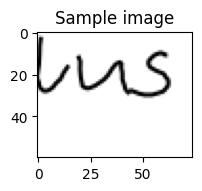

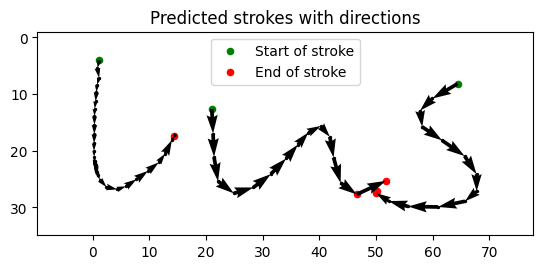

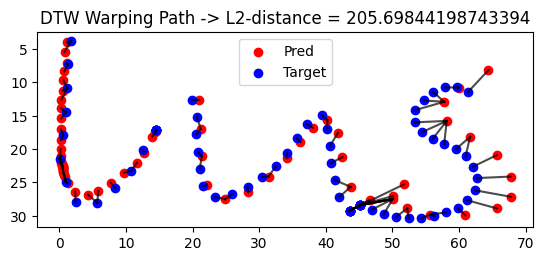

   Batch: 0    | Width: 6   | Loss: 5.7361
   Batch: 100  | Width: 46  | Loss: 3.0274
   Batch: 200  | Width: 56  | Loss: 2.7183
   Batch: 300  | Width: 64  | Loss: 3.0638
   Batch: 400  | Width: 72  | Loss: 3.1512
   Batch: 500  | Width: 78  | Loss: 2.4723
   Batch: 600  | Width: 84  | Loss: 2.5784
   Batch: 700  | Width: 90  | Loss: 2.9206
   Batch: 800  | Width: 96  | Loss: 3.4453

Epoch: 57 | Loss: 3.2602937073082554


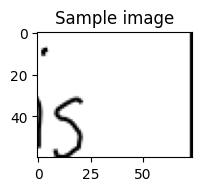

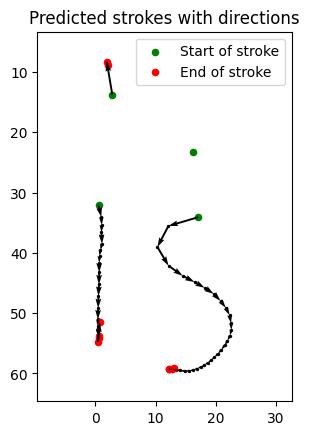

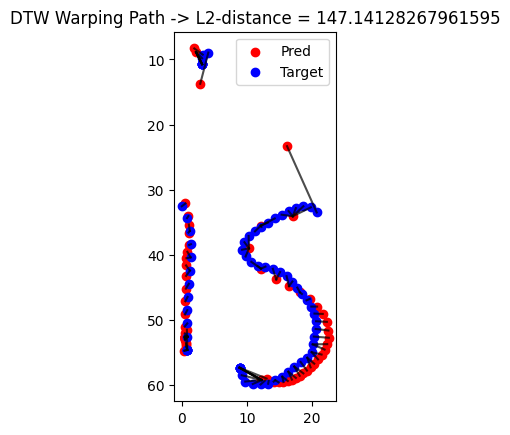

   Batch: 0    | Width: 6   | Loss: 5.6595
   Batch: 100  | Width: 46  | Loss: 2.9898
   Batch: 200  | Width: 56  | Loss: 2.6927
   Batch: 300  | Width: 64  | Loss: 2.9826
   Batch: 400  | Width: 72  | Loss: 3.1834
   Batch: 500  | Width: 78  | Loss: 2.4762
   Batch: 600  | Width: 84  | Loss: 2.4893
   Batch: 700  | Width: 90  | Loss: 2.8030
   Batch: 800  | Width: 96  | Loss: 3.3924

Epoch: 58 | Loss: 3.260075348629048


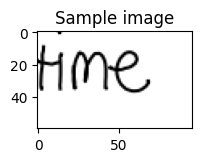

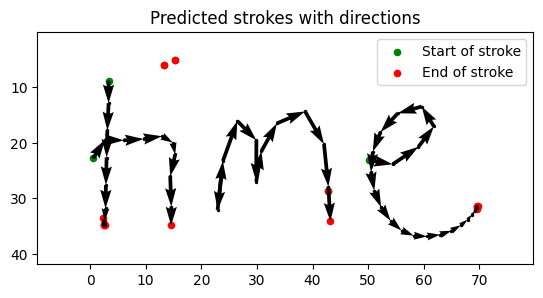

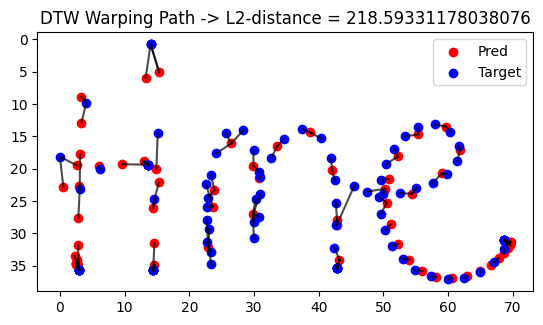

   Batch: 0    | Width: 6   | Loss: 5.9920
   Batch: 100  | Width: 46  | Loss: 3.0437
   Batch: 200  | Width: 56  | Loss: 2.6814
   Batch: 300  | Width: 64  | Loss: 2.8800
   Batch: 400  | Width: 72  | Loss: 3.1390
   Batch: 500  | Width: 78  | Loss: 2.4515
   Batch: 600  | Width: 84  | Loss: 2.4508
   Batch: 700  | Width: 90  | Loss: 2.6882
   Batch: 800  | Width: 96  | Loss: 3.3408

Epoch: 59 | Loss: 3.170692684978088


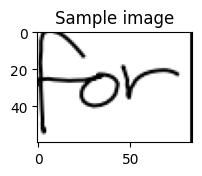

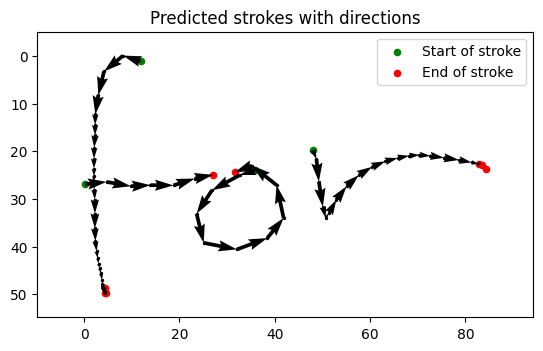

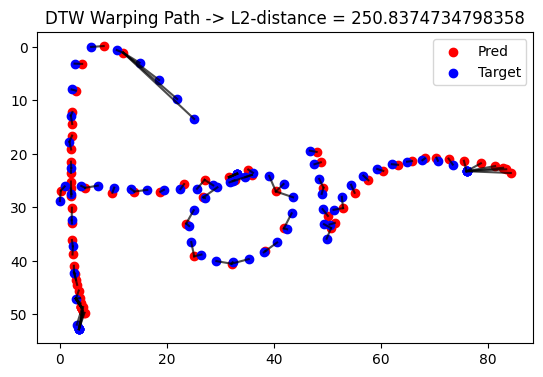

   Batch: 0    | Width: 6   | Loss: 5.5317
   Batch: 100  | Width: 46  | Loss: 2.9683
   Batch: 200  | Width: 56  | Loss: 2.6350
   Batch: 300  | Width: 64  | Loss: 2.7695
   Batch: 400  | Width: 72  | Loss: 3.0253
   Batch: 500  | Width: 78  | Loss: 2.6498
   Batch: 600  | Width: 84  | Loss: 2.6005
   Batch: 700  | Width: 90  | Loss: 3.0360
   Batch: 800  | Width: 96  | Loss: 3.5359


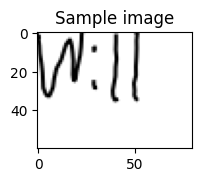

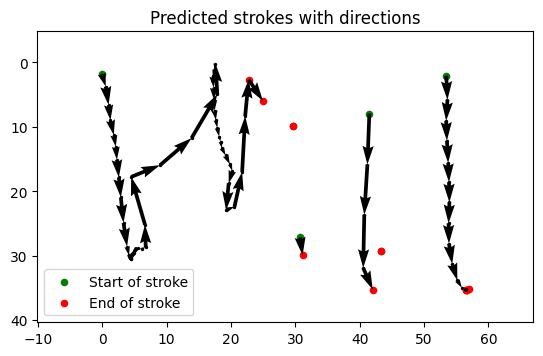

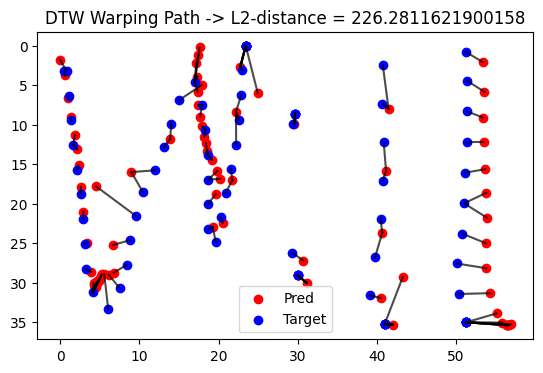

   Batch: 0    | Width: 6   | Loss: 5.9551
   Batch: 100  | Width: 46  | Loss: 3.0792
   Batch: 200  | Width: 56  | Loss: 2.6073
   Batch: 300  | Width: 64  | Loss: 2.7793
   Batch: 400  | Width: 72  | Loss: 3.0669
   Batch: 500  | Width: 78  | Loss: 2.5708
   Batch: 700  | Width: 90  | Loss: 2.8167
   Batch: 800  | Width: 96  | Loss: 3.1869

Epoch: 61 | Loss: 3.0300007653527343


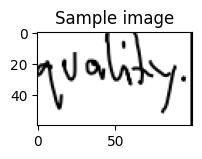

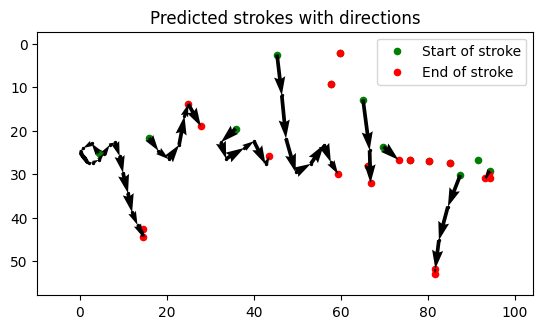

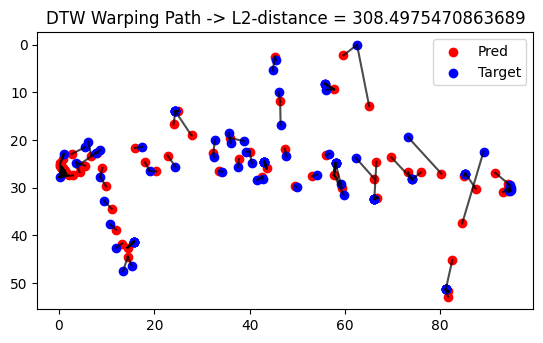

   Batch: 0    | Width: 6   | Loss: 5.4924
   Batch: 100  | Width: 46  | Loss: 2.9403
   Batch: 200  | Width: 56  | Loss: 2.5651
   Batch: 300  | Width: 64  | Loss: 2.8323
   Batch: 400  | Width: 72  | Loss: 3.0551
   Batch: 500  | Width: 78  | Loss: 2.3639
   Batch: 600  | Width: 84  | Loss: 2.4372
   Batch: 700  | Width: 90  | Loss: 2.5682
   Batch: 800  | Width: 96  | Loss: 3.3226

Epoch: 62 | Loss: 3.229296335205859


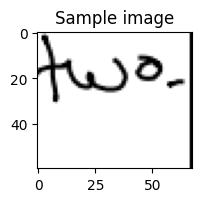

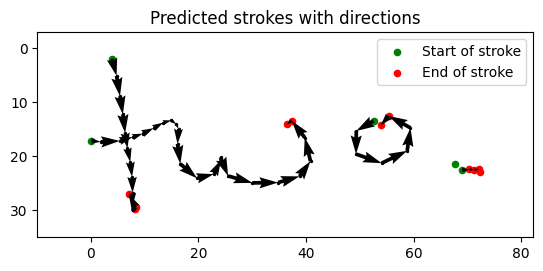

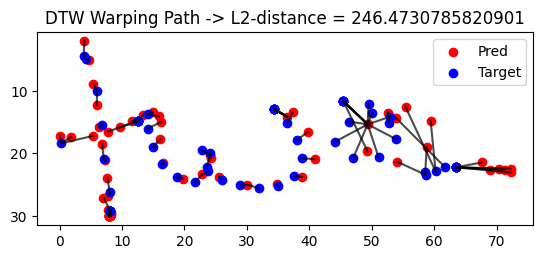

   Batch: 0    | Width: 6   | Loss: 5.9367
   Batch: 100  | Width: 46  | Loss: 2.9670
   Batch: 200  | Width: 56  | Loss: 2.5817
   Batch: 300  | Width: 64  | Loss: 2.7164
   Batch: 400  | Width: 72  | Loss: 3.0038
   Batch: 500  | Width: 78  | Loss: 2.5077
   Batch: 600  | Width: 84  | Loss: 2.3960
   Batch: 700  | Width: 90  | Loss: 2.6698
   Batch: 800  | Width: 96  | Loss: 3.2069

Epoch: 63 | Loss: 3.1350891891092725


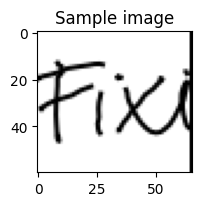

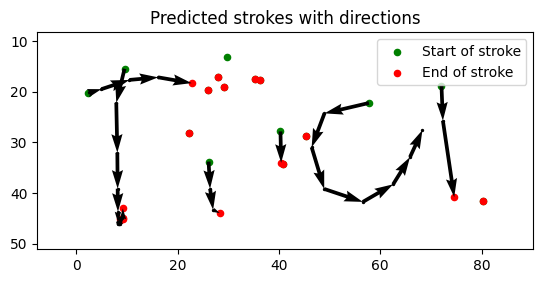

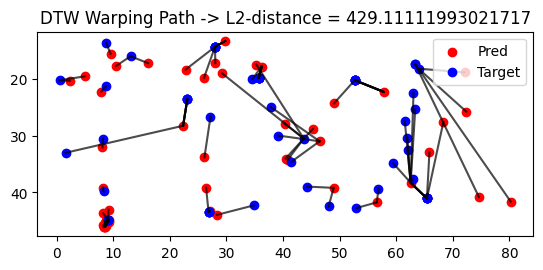

   Batch: 0    | Width: 6   | Loss: 5.6967
   Batch: 100  | Width: 46  | Loss: 2.8857
   Batch: 200  | Width: 56  | Loss: 2.5241
   Batch: 300  | Width: 64  | Loss: 2.6352
   Batch: 400  | Width: 72  | Loss: 2.9440
   Batch: 500  | Width: 78  | Loss: 2.3783
   Batch: 600  | Width: 84  | Loss: 2.4210
   Batch: 700  | Width: 90  | Loss: 2.7472
   Batch: 800  | Width: 96  | Loss: 3.2315

Epoch: 64 | Loss: 3.1896531113198594


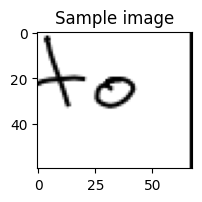

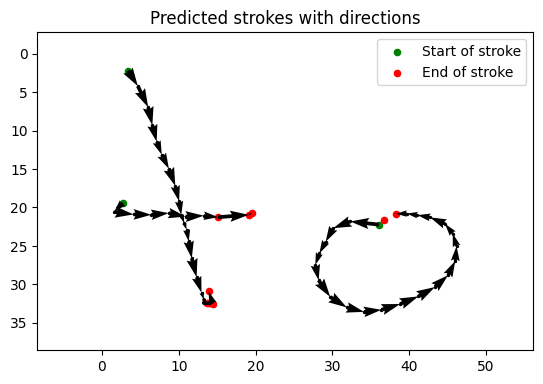

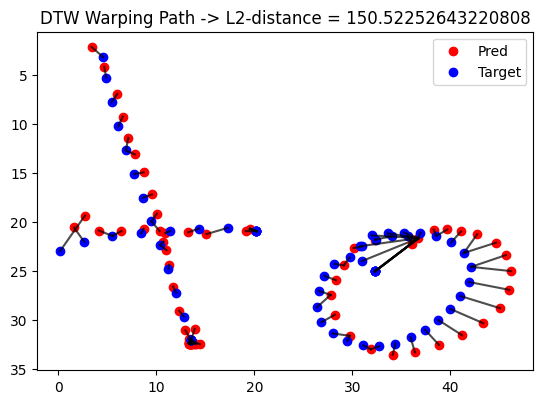

   Batch: 0    | Width: 6   | Loss: 5.5221
   Batch: 100  | Width: 46  | Loss: 2.8911
   Batch: 200  | Width: 56  | Loss: 2.5085
   Batch: 300  | Width: 64  | Loss: 2.5782
   Batch: 400  | Width: 72  | Loss: 2.9504
   Batch: 500  | Width: 78  | Loss: 2.4927
   Batch: 600  | Width: 84  | Loss: 2.4577
   Batch: 700  | Width: 90  | Loss: 2.6759
   Batch: 800  | Width: 96  | Loss: 3.2581

Epoch: 65 | Loss: 3.1525691427474367


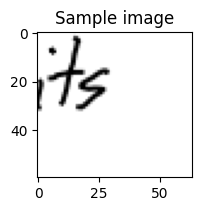

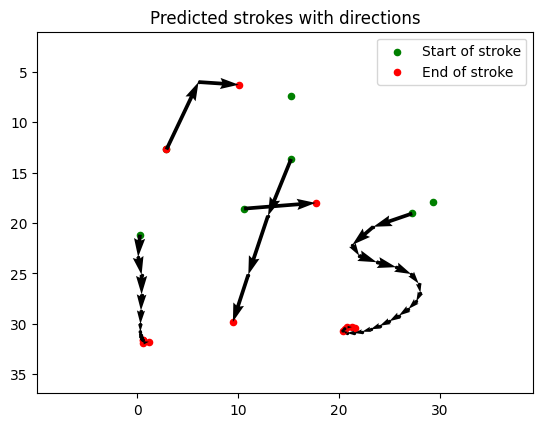

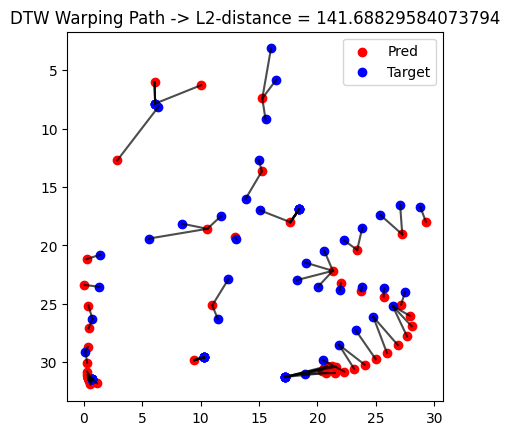

   Batch: 0    | Width: 6   | Loss: 5.9484
   Batch: 100  | Width: 46  | Loss: 2.8850
   Batch: 200  | Width: 56  | Loss: 2.5145
   Batch: 300  | Width: 64  | Loss: 2.8147
   Batch: 400  | Width: 72  | Loss: 3.0883
   Batch: 500  | Width: 78  | Loss: 2.5933
   Batch: 600  | Width: 84  | Loss: 2.5932
   Batch: 700  | Width: 90  | Loss: 2.6218
   Batch: 800  | Width: 96  | Loss: 3.2258

Epoch: 66 | Loss: 3.2197346718033777


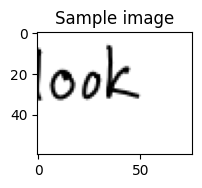

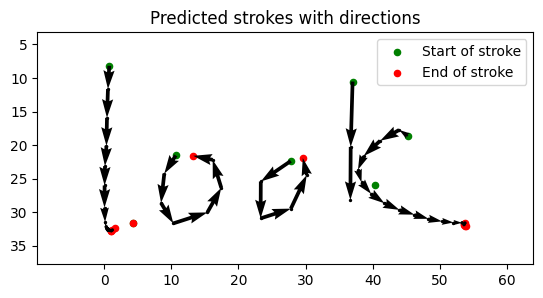

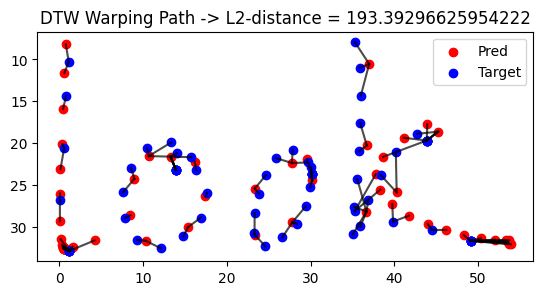

   Batch: 0    | Width: 6   | Loss: 5.8800
   Batch: 100  | Width: 46  | Loss: 2.8023
   Batch: 200  | Width: 56  | Loss: 2.5105
   Batch: 300  | Width: 64  | Loss: 2.6505
   Batch: 400  | Width: 72  | Loss: 2.9235
   Batch: 500  | Width: 78  | Loss: 2.3696
   Batch: 600  | Width: 84  | Loss: 2.4072
   Batch: 700  | Width: 90  | Loss: 2.6212
   Batch: 800  | Width: 96  | Loss: 3.1885

Epoch: 67 | Loss: 2.9616321716909955


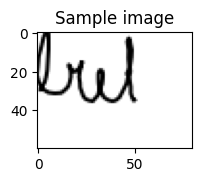

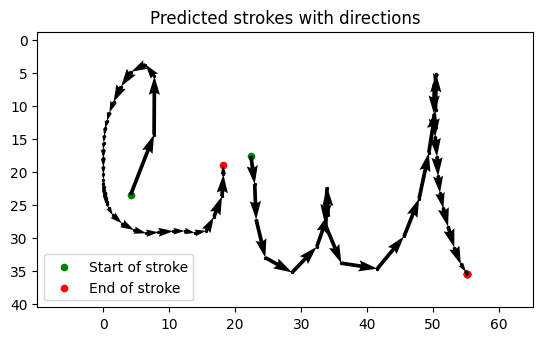

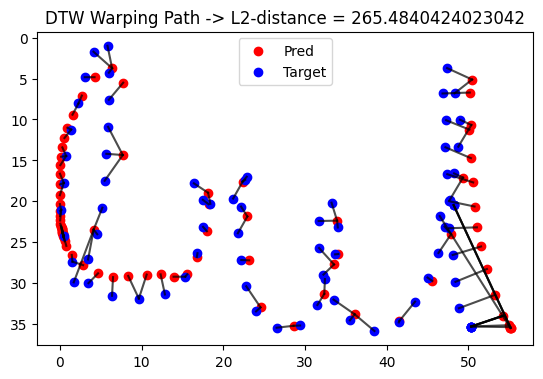

   Batch: 0    | Width: 6   | Loss: 5.8267
   Batch: 100  | Width: 46  | Loss: 2.7213
   Batch: 200  | Width: 56  | Loss: 2.5937
   Batch: 300  | Width: 64  | Loss: 2.6156
   Batch: 400  | Width: 72  | Loss: 2.9613
   Batch: 500  | Width: 78  | Loss: 2.3455
   Batch: 600  | Width: 84  | Loss: 2.4411
   Batch: 700  | Width: 90  | Loss: 2.8985
   Batch: 800  | Width: 96  | Loss: 3.1566

Epoch: 68 | Loss: 3.147018250642958


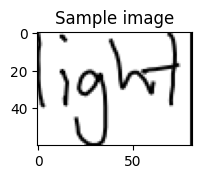

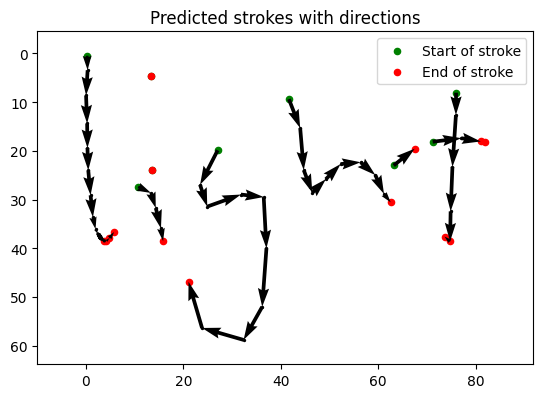

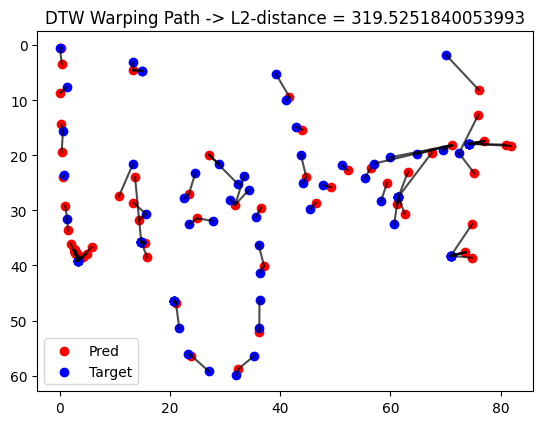

   Batch: 0    | Width: 6   | Loss: 5.5152
   Batch: 100  | Width: 46  | Loss: 2.9316
   Batch: 200  | Width: 56  | Loss: 2.4665
   Batch: 300  | Width: 64  | Loss: 2.7062
   Batch: 400  | Width: 72  | Loss: 2.8550
   Batch: 500  | Width: 78  | Loss: 2.2785
   Batch: 600  | Width: 84  | Loss: 2.4083
   Batch: 700  | Width: 90  | Loss: 2.5954
   Batch: 800  | Width: 96  | Loss: 3.1441

Epoch: 69 | Loss: 3.101040232113147


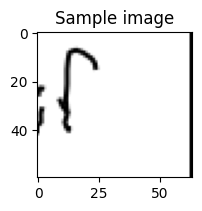

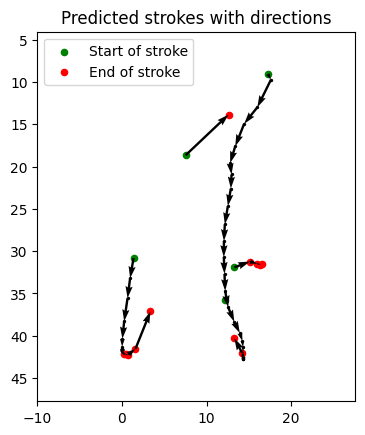

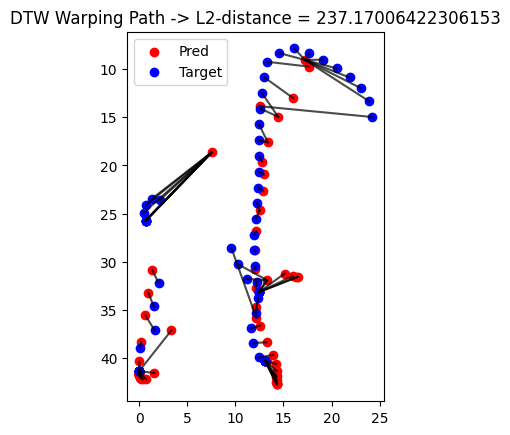

   Batch: 0    | Width: 6   | Loss: 5.5950
   Batch: 100  | Width: 46  | Loss: 2.7017
   Batch: 200  | Width: 56  | Loss: 2.5289
   Batch: 300  | Width: 64  | Loss: 2.5774
   Batch: 400  | Width: 72  | Loss: 2.8594
   Batch: 500  | Width: 78  | Loss: 2.3584
   Batch: 600  | Width: 84  | Loss: 2.3798
   Batch: 700  | Width: 90  | Loss: 2.5789
   Batch: 800  | Width: 96  | Loss: 3.1275

Epoch: 70 | Loss: 3.1037528862322525


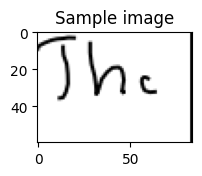

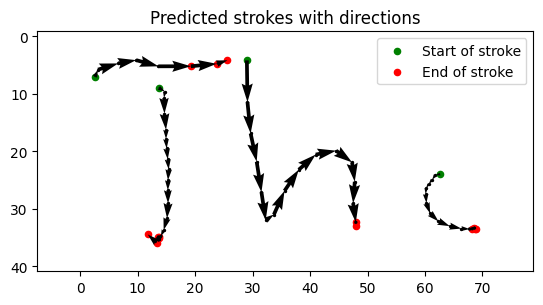

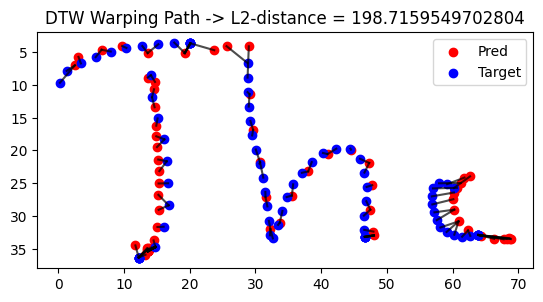

   Batch: 0    | Width: 6   | Loss: 5.5352
   Batch: 100  | Width: 46  | Loss: 2.7335
   Batch: 200  | Width: 56  | Loss: 2.4676
   Batch: 300  | Width: 64  | Loss: 2.5056
   Batch: 400  | Width: 72  | Loss: 2.7902
   Batch: 500  | Width: 78  | Loss: 2.2434
   Batch: 600  | Width: 84  | Loss: 2.4069
   Batch: 700  | Width: 90  | Loss: 2.5648
   Batch: 800  | Width: 96  | Loss: 3.1834

Epoch: 71 | Loss: 2.984032174994405


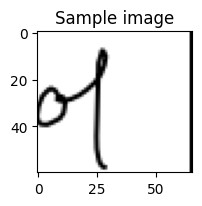

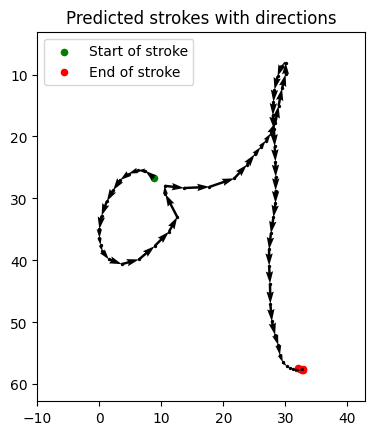

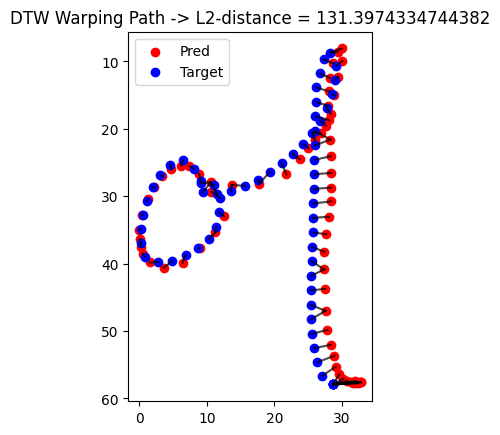

   Batch: 0    | Width: 6   | Loss: 5.7510
   Batch: 100  | Width: 46  | Loss: 2.8259
   Batch: 200  | Width: 56  | Loss: 2.4434
   Batch: 300  | Width: 64  | Loss: 2.5647
   Batch: 400  | Width: 72  | Loss: 2.7050
   Batch: 500  | Width: 78  | Loss: 2.3282
   Batch: 600  | Width: 84  | Loss: 2.3147
   Batch: 700  | Width: 90  | Loss: 2.5307
   Batch: 800  | Width: 96  | Loss: 3.1095

Epoch: 72 | Loss: 3.17049389138511


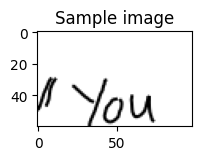

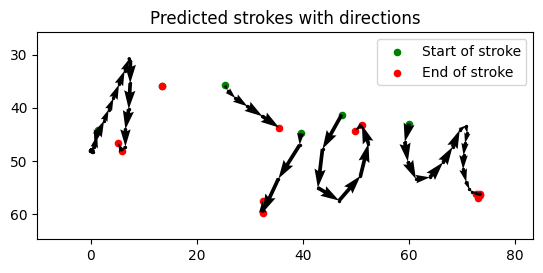

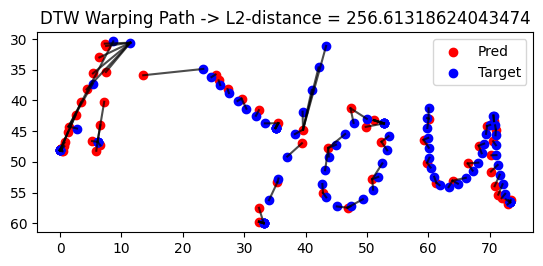

   Batch: 0    | Width: 6   | Loss: 5.3499
   Batch: 100  | Width: 46  | Loss: 2.6901
   Batch: 200  | Width: 56  | Loss: 2.3664
   Batch: 300  | Width: 64  | Loss: 2.5097
   Batch: 400  | Width: 72  | Loss: 2.7876
   Batch: 500  | Width: 78  | Loss: 2.3421
   Batch: 600  | Width: 84  | Loss: 2.3316
   Batch: 700  | Width: 90  | Loss: 2.5317
   Batch: 800  | Width: 96  | Loss: 2.9672

Epoch: 73 | Loss: 3.047328290754482


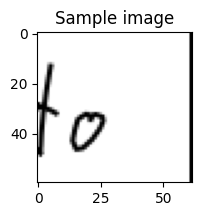

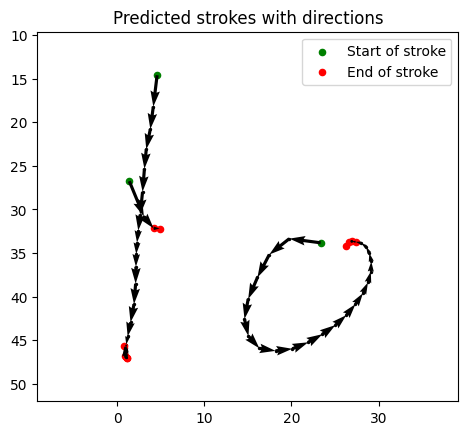

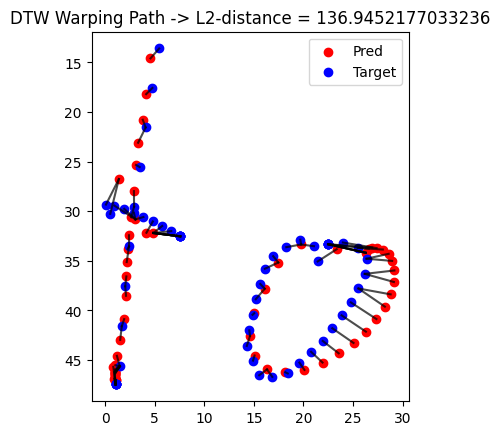

   Batch: 0    | Width: 6   | Loss: 5.9114
   Batch: 100  | Width: 46  | Loss: 2.6755
   Batch: 200  | Width: 56  | Loss: 2.5141
   Batch: 300  | Width: 64  | Loss: 2.5304
   Batch: 400  | Width: 72  | Loss: 2.9262
   Batch: 500  | Width: 78  | Loss: 2.1957
   Batch: 600  | Width: 84  | Loss: 2.3974
   Batch: 700  | Width: 90  | Loss: 2.4655
   Batch: 800  | Width: 96  | Loss: 3.1154

Epoch: 74 | Loss: 3.108000579606307


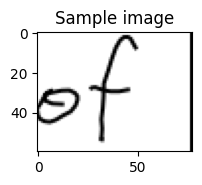

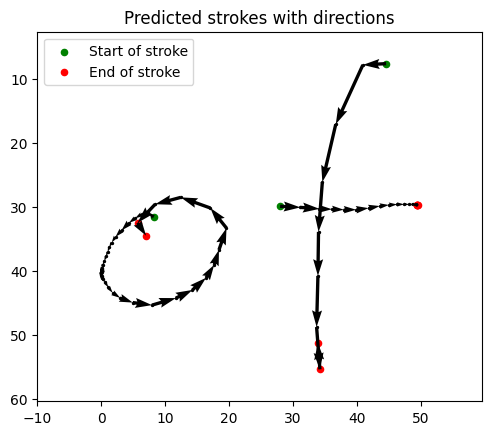

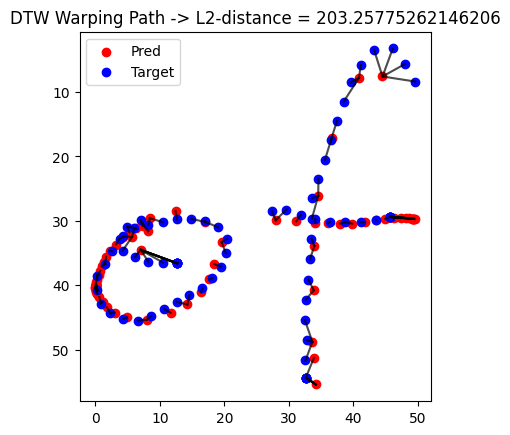

   Batch: 0    | Width: 6   | Loss: 5.5120
   Batch: 100  | Width: 46  | Loss: 2.8764
   Batch: 200  | Width: 56  | Loss: 2.5243
   Batch: 300  | Width: 64  | Loss: 2.5497
   Batch: 400  | Width: 72  | Loss: 2.8718
   Batch: 500  | Width: 78  | Loss: 2.2949
   Batch: 600  | Width: 84  | Loss: 2.2833
   Batch: 700  | Width: 90  | Loss: 2.5115
   Batch: 800  | Width: 96  | Loss: 3.0635


In [15]:
# Fitting the model
losses = model_fit(model, dataloader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint_interval, plot=1)

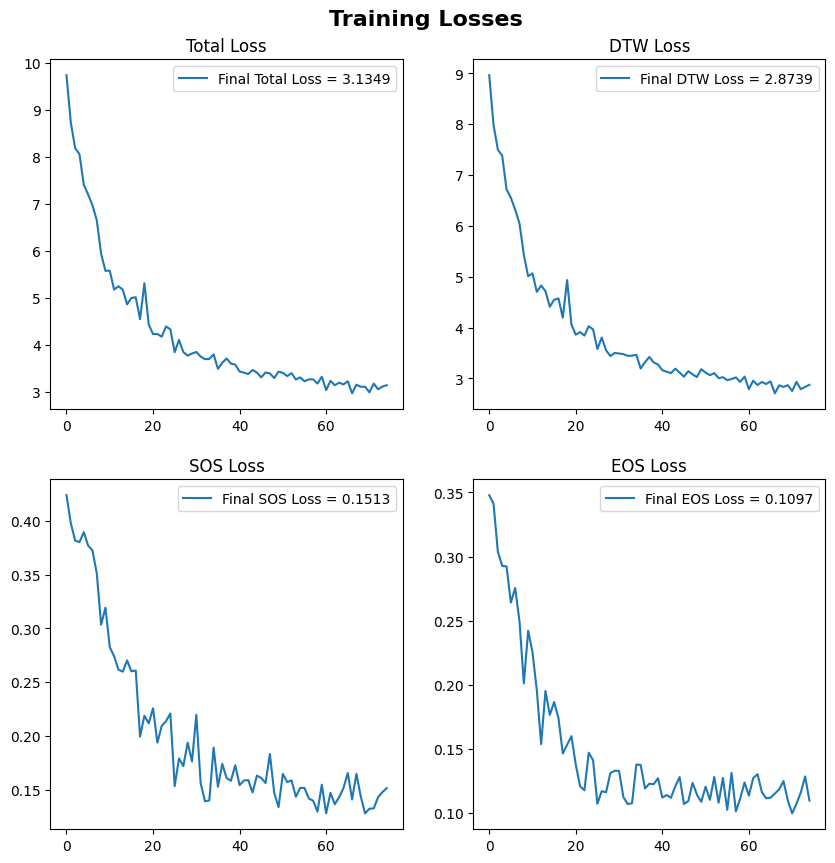

In [16]:
plot_losses(losses)